<a href="https://colab.research.google.com/github/NoorFatimaMemon/disease-prediction-analysis-for-DRC/blob/main/predict_disease_cases.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Disease Prediction and Analysis for Democratic Republic of Congo (2024)**

In [91]:
!pip install pmdarima

In [166]:
# Importing Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from prophet.diagnostics import cross_validation, performance_metrics
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
import matplotlib.dates as mdates
from statsmodels.tsa.stattools import adfuller
import pmdarima as pm
import warnings
warnings.filterwarnings('ignore')

In [93]:
# Load the data
df = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Time_Series/2020to23DRCasesin0to11months_(1yrto5yr_kids).xlsx', sheet_name='Feuil1', parse_dates=["debutsem"])

In [94]:
# Drop unnecessary columns
df = df.drop(columns=["num", "pays", "numsem", "maladie", "casageinc", "decageinc", "totalcas", "totaldeces", "letal", "attaq"], errors='ignore')
# Convert categorical columns to uppercase to ensure consistency
df["prov"] = df["prov"].str.upper()
df["zs"] = df["zs"].str.upper()
# Total number of unique provinces & districts
total_provinces = df['prov'].nunique()
total_districts = df['zs'].nunique()
print(f"Total number of unique provinces: {total_provinces}")
print(f"Total number of unique districts: {total_districts}")

Total number of unique provinces: 22
Total number of unique districts: 219


In [95]:
# Convert debutsem (Week Start) from Excel serial date to proper datetime
df["debutsem"] = pd.to_numeric(df["debutsem"], errors="coerce") # Convert to numeric, invalid parsing will be set as NaN
df["debutsem"] = pd.to_datetime(df["debutsem"], origin="1899-12-30", unit="D")

In [96]:
df.shape

(4637, 11)

In [97]:
df.head()

prov              zs  pop   debutsem  c011mois  d011mois  \
0  HAUT-KATANGA          KATUBA  NaN 2019-12-30       NaN       NaN   
1  HAUT-KATANGA  MUFUNGA-SAMPWE  NaN 2019-12-30       NaN       NaN   
2  HAUT-KATANGA        MUMBUNDA  NaN 2019-12-30       NaN       NaN   
3  HAUT-KATANGA           KILWA  NaN 2019-12-30       NaN       NaN   
4  HAUT-KATANGA       KAMALONDO  NaN 2019-12-30       NaN       NaN   

   c1259mois  d1259mois  c5ansp  d5ansp  Annee  
0        0.0        0.0     6.0     0.0   2020  
1        1.0        0.0     2.0     0.0   2020  
2        0.0        0.0     1.0     0.0   2020  
3        0.0        0.0     2.0     0.0   2020  
4        0.0        0.0     1.0     0.0   2020

In [98]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4637 entries, 0 to 4636
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   prov       4637 non-null   object        
 1   zs         4637 non-null   object        
 2   pop        2625 non-null   float64       
 3   debutsem   4579 non-null   datetime64[ns]
 4   c011mois   2586 non-null   float64       
 5   d011mois   2584 non-null   float64       
 6   c1259mois  4575 non-null   float64       
 7   d1259mois  4566 non-null   float64       
 8   c5ansp     4589 non-null   float64       
 9   d5ansp     4566 non-null   float64       
 10  Annee      4637 non-null   int64         
dtypes: datetime64[ns](1), float64(7), int64(1), object(2)
memory usage: 398.6+ KB


In [99]:
df.describe()

pop                       debutsem     c011mois     d011mois  \
count    2625.000000                           4579  2586.000000  2584.000000   
mean   201431.303238  2021-06-23 15:25:49.595981824     0.587007     0.004257   
min         9.000000            2012-11-05 00:00:00     0.000000     0.000000   
25%    121642.000000            2020-07-13 00:00:00     0.000000     0.000000   
50%    166424.000000            2021-04-01 00:00:00     0.000000     0.000000   
75%    242153.000000            2022-05-30 00:00:00     0.000000     0.000000   
max    685789.000000            2102-06-06 00:00:00    66.000000     2.000000   
std    108345.764747                            NaN     3.595663     0.081015   

         c1259mois    d1259mois       c5ansp       d5ansp        Annee  
count  4575.000000  4566.000000  4589.000000  4566.000000  4637.000000  
mean      2.603716     0.025186     5.257355     0.089137  2021.015959  
min       0.000000     0.000000     0.000000     0.000000  2020.000000  
25%       0.000000     0.000000     0.000000     0.000000  2020.000000  
50%       0.000000     0.000000     2.000000     0.000000  2021.000000  
75%       2.000000     0.000000     5.000000     0.000000  2022.000000  
max     194.000000     9.000000   390.000000    14.000000  2023.000000  
std       8.245025     0.219580    12.593859     0.468673     1.006109

In [100]:
# Check for missing values
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])

pop          2012
debutsem       58
c011mois     2051
d011mois     2053
c1259mois      62
d1259mois      71
c5ansp         48
d5ansp         71
dtype: int64


In [101]:
# Check for duplicates
df.duplicated().sum()

30

# **Exploratory Data Analysis**

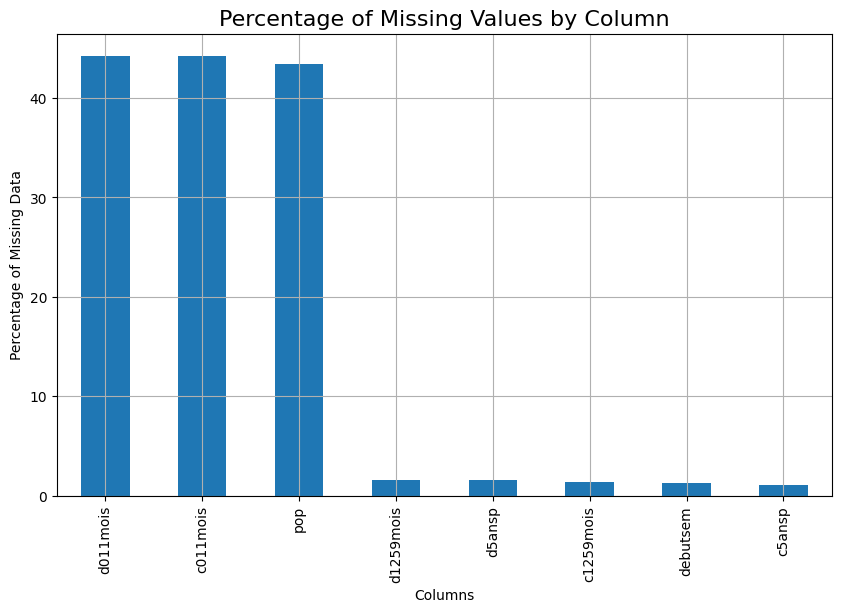

In [102]:
# Calculate the percentage of missing values in each column
missing_data_percent = df.isnull().mean() * 100

# Plot the missing data percentages for columns with missing values
plt.figure(figsize=(10, 6))
missing_data_percent[missing_data_percent > 0].sort_values(ascending=False).plot(kind='bar')
plt.title('Percentage of Missing Values by Column', fontsize=16)
plt.xlabel('Columns')
plt.ylabel('Percentage of Missing Data')
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

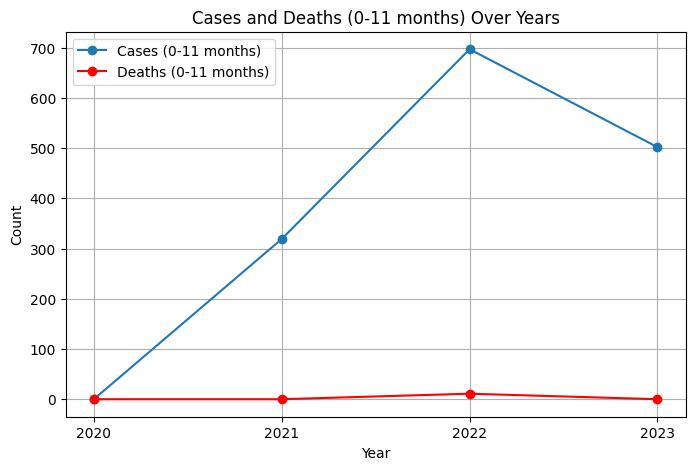

In [103]:
# Plot Total Cases and Deaths in children 0-11 months over Year
plt.figure(figsize=(8, 5))
yearly_data = df.groupby("Annee")[["c011mois", "d011mois"]].sum()
plt.plot(yearly_data.index, yearly_data["c011mois"], label="Cases (0-11 months)", marker="o")
plt.plot(yearly_data.index, yearly_data["d011mois"], label="Deaths (0-11 months)", marker="o", color='red')
# Force x-axis to use only whole number years
plt.xticks(yearly_data.index.astype(int))
plt.legend()
plt.title("Cases and Deaths (0-11 months) Over Years")
plt.xlabel("Year")
plt.ylabel("Count")
plt.grid()
plt.show()

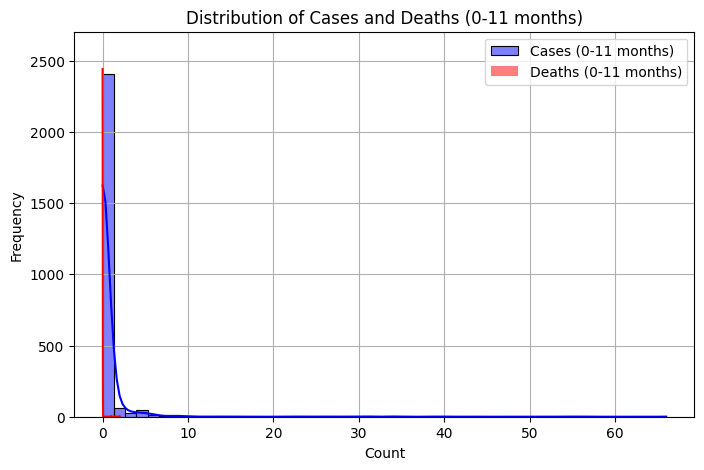

In [104]:
# Distribution of Cases and Deaths in children 0-11 months
plt.figure(figsize=(8, 5))
sns.histplot(df["c011mois"], bins=50, kde=True, color='blue', label='Cases (0-11 months)')
sns.histplot(df["d011mois"], bins=50, kde=True, color='red', label='Deaths (0-11 months)')
plt.legend()
plt.title("Distribution of Cases and Deaths (0-11 months)")
plt.xlabel("Count")
plt.ylabel("Frequency")
plt.grid()
plt.show()

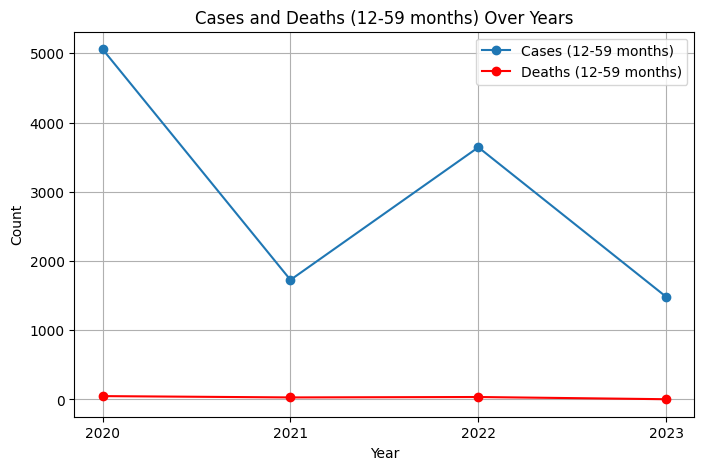

In [105]:
# Plot Total Cases and Deaths in children 12-59 months over Year
plt.figure(figsize=(8, 5))
yearly_data = df.groupby("Annee")[["c1259mois", "d1259mois"]].sum()
plt.plot(yearly_data.index, yearly_data["c1259mois"], label="Cases (12-59 months)", marker="o")
plt.plot(yearly_data.index, yearly_data["d1259mois"], label="Deaths (12-59 months)", marker="o", color='red')
# Force x-axis to use only whole number years
plt.xticks(yearly_data.index.astype(int))
plt.legend()
plt.title("Cases and Deaths (12-59 months) Over Years")
plt.xlabel("Year")
plt.ylabel("Count")
plt.grid()
plt.show()

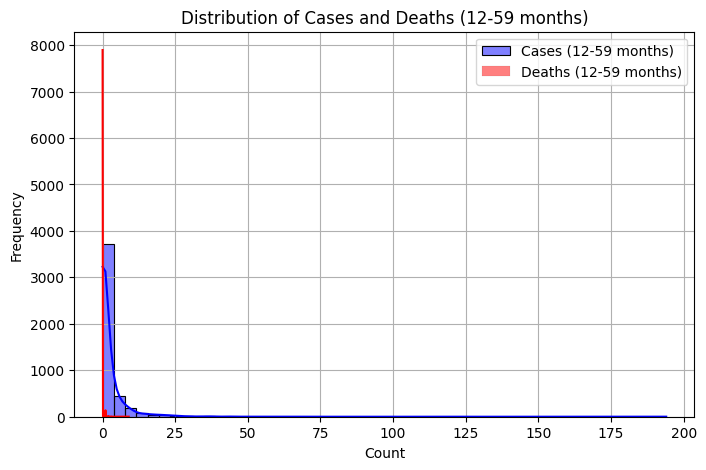

In [106]:
# Distribution of Cases and Deaths in children 12-59 months
plt.figure(figsize=(8, 5))
sns.histplot(df["c1259mois"], bins=50, kde=True, color='blue', label='Cases (12-59 months)')
sns.histplot(df["d1259mois"], bins=50, kde=True, color='red', label='Deaths (12-59 months)')
plt.legend()
plt.title("Distribution of Cases and Deaths (12-59 months)")
plt.xlabel("Count")
plt.ylabel("Frequency")
plt.grid()
plt.show()

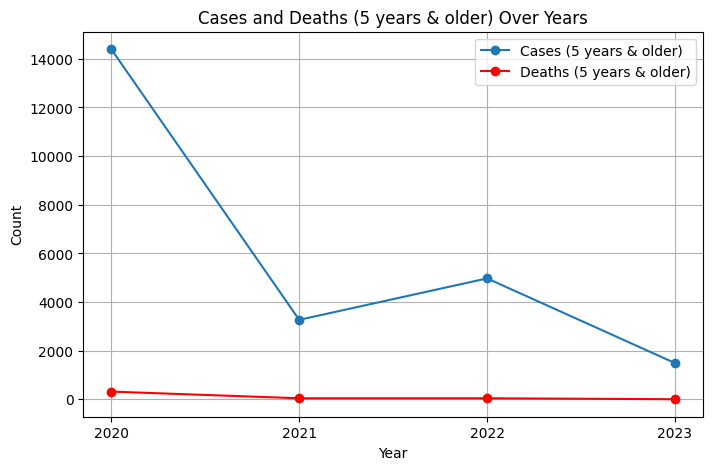

In [107]:
# Plot Total Cases and Deaths in children 5 years & older over Year
plt.figure(figsize=(8, 5))
yearly_data = df.groupby("Annee")[["c5ansp", "d5ansp"]].sum()
plt.plot(yearly_data.index, yearly_data["c5ansp"], label="Cases (5 years & older)", marker="o")
plt.plot(yearly_data.index, yearly_data["d5ansp"], label="Deaths (5 years & older)", marker="o", color='red')
# Force x-axis to use only whole number years
plt.xticks(yearly_data.index.astype(int))
plt.legend()
plt.title("Cases and Deaths (5 years & older) Over Years")
plt.xlabel("Year")
plt.ylabel("Count")
plt.grid()
plt.show()

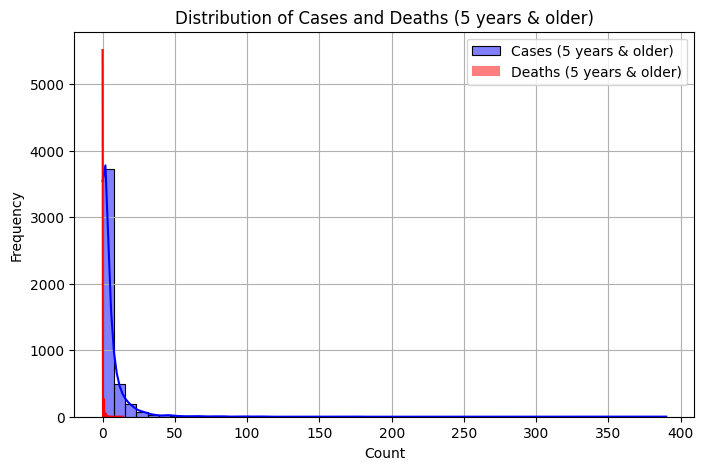

In [108]:
# Distribution of Cases and Deaths in children 5 years & older
plt.figure(figsize=(8, 5))
sns.histplot(df["c5ansp"], bins=50, kde=True, color='blue', label='Cases (5 years & older)')
sns.histplot(df["d5ansp"], bins=50, kde=True, color='red', label='Deaths (5 years & older)')
plt.legend()
plt.title("Distribution of Cases and Deaths (5 years & older)")
plt.xlabel("Count")
plt.ylabel("Frequency")
plt.grid()
plt.show()

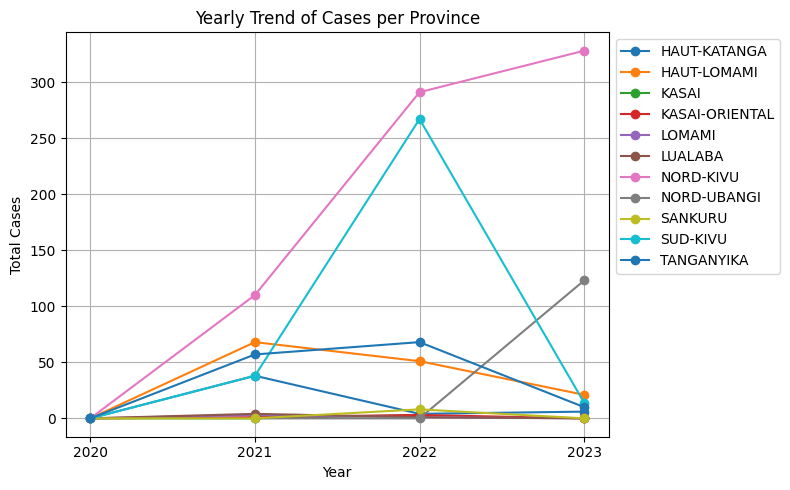

In [109]:
# Line plot for yearly trend per province
df_grouped_year_prov = df.groupby(["Annee", "prov"])[["c011mois", "c1259mois", "c5ansp"]].sum().unstack()
plt.figure(figsize=(8, 5))
plotted_provinces = []
for prov in df_grouped_year_prov.columns.levels[1]:
    y_values = df_grouped_year_prov["c011mois", prov]
    # Check if there is at least one non-zero or non-NaN value before plotting
    if y_values.notna().sum() > 0 and y_values.sum() > 0:
        plt.plot(df_grouped_year_prov.index, y_values, marker="o", label=prov)
        plotted_provinces.append(prov)  # Keep track of displayed provinces

# Show legend only for plotted provinces
if plotted_provinces:
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.title("Yearly Trend of Cases per Province")
plt.xlabel("Year")
plt.ylabel("Total Cases")
plt.grid()
# Set x-axis ticks using yearly_data index
plt.xticks(yearly_data.index.astype(int))
plt.tight_layout()
plt.show()

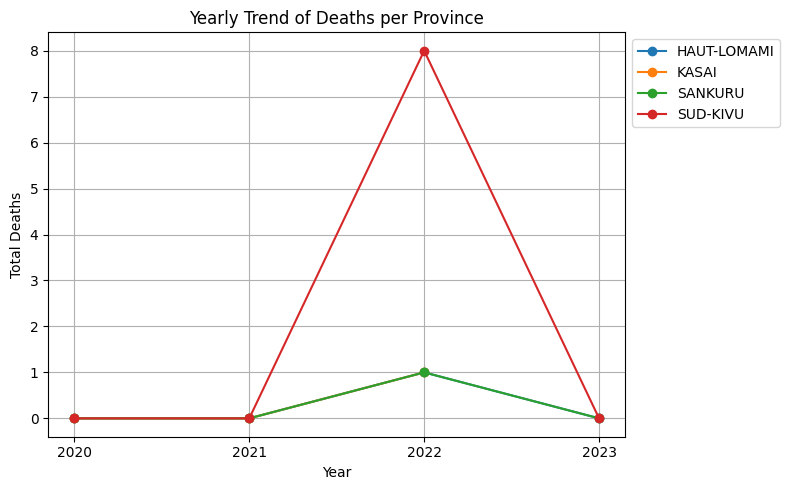

In [110]:
# Line plot for yearly trend per province
df_grouped_year_prov = df.groupby(["Annee", "prov"])[["d011mois", "d1259mois", "d5ansp"]].sum().unstack()
plt.figure(figsize=(8, 5))
plotted_provinces = []
for prov in df_grouped_year_prov.columns.levels[1]:
    y_values = df_grouped_year_prov["d011mois", prov]
    # Check if there is at least one non-zero or non-NaN value before plotting
    if y_values.notna().sum() > 0 and y_values.sum() > 0:
        plt.plot(df_grouped_year_prov.index, y_values, marker="o", label=prov)
        plotted_provinces.append(prov)  # Keep track of displayed provinces

# Show legend only for plotted provinces
if plotted_provinces:
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.title("Yearly Trend of Deaths per Province")
plt.xlabel("Year")
plt.ylabel("Total Deaths")
plt.grid()
# Set x-axis ticks using yearly_data index
plt.xticks(yearly_data.index.astype(int))
plt.tight_layout()
plt.show()

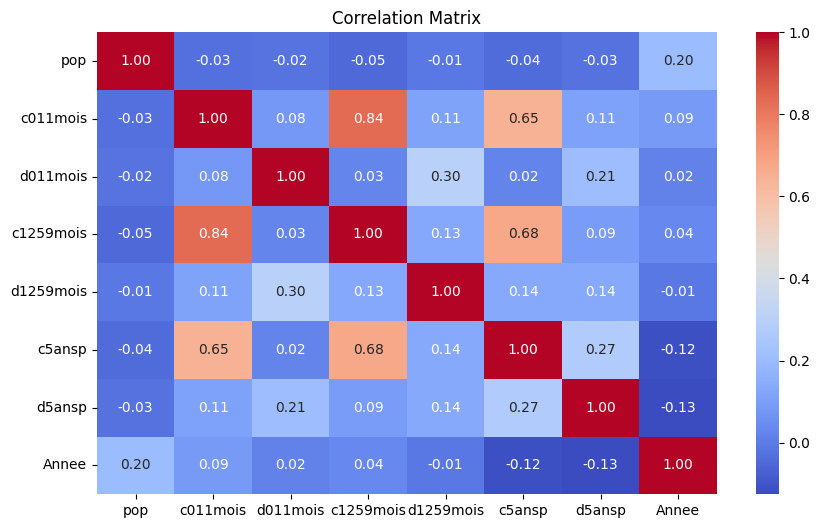

In [111]:
# Correlation heatmap for numerical columns only
plt.figure(figsize=(10, 6))
numerical_df = df.select_dtypes(include=np.number)  # Select only numerical columns
sns.heatmap(numerical_df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

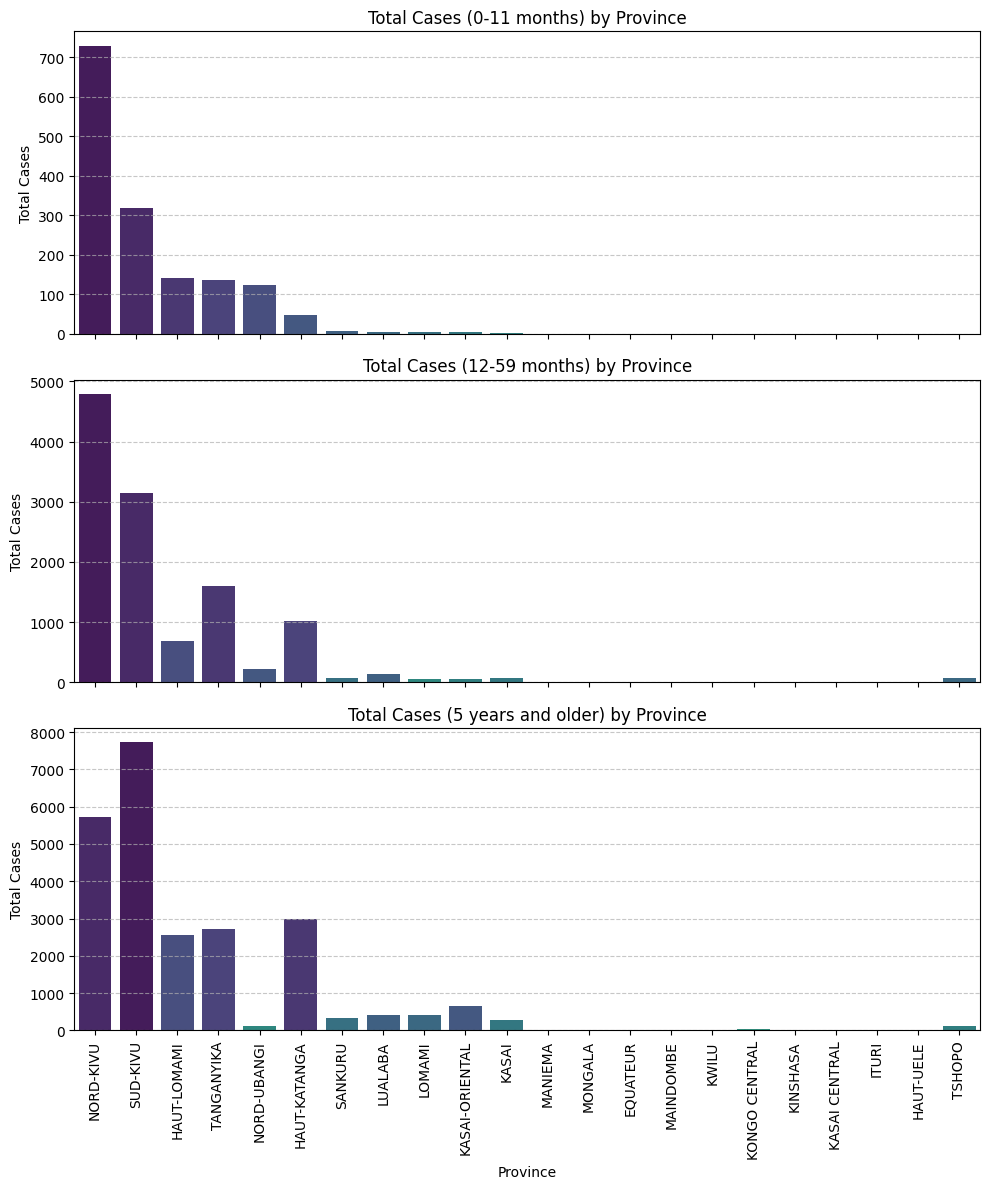

In [112]:
# Total Cases by Province
# Group data by province for different age groups
df_grouped_prov_0_11 = df.groupby("prov")["c011mois"].sum().sort_values(ascending=False)
df_grouped_prov_12_59 = df.groupby("prov")["c1259mois"].sum().sort_values(ascending=False)
df_grouped_prov_5plus = df.groupby("prov")["c5ansp"].sum().sort_values(ascending=False)
fig, axes = plt.subplots(3, 1, figsize=(10, 12), sharex=True)

# Define categories and titles
categories = [df_grouped_prov_0_11, df_grouped_prov_12_59, df_grouped_prov_5plus]
titles = ["Total Cases (0-11 months) by Province", "Total Cases (12-59 months) by Province", "Total Cases (5 years and older) by Province"]
for i, (data, title) in enumerate(zip(categories, titles)):
    sns.barplot(x=data.index, y=data.values, ax=axes[i], palette="viridis")
    axes[i].set_title(title)
    axes[i].set_ylabel("Total Cases")
    axes[i].grid(axis="y", linestyle="--", alpha=0.7)  # Add grid lines to the y-axis

# Set x-axis labels only for the last plot
axes[-1].set_xlabel("Province")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

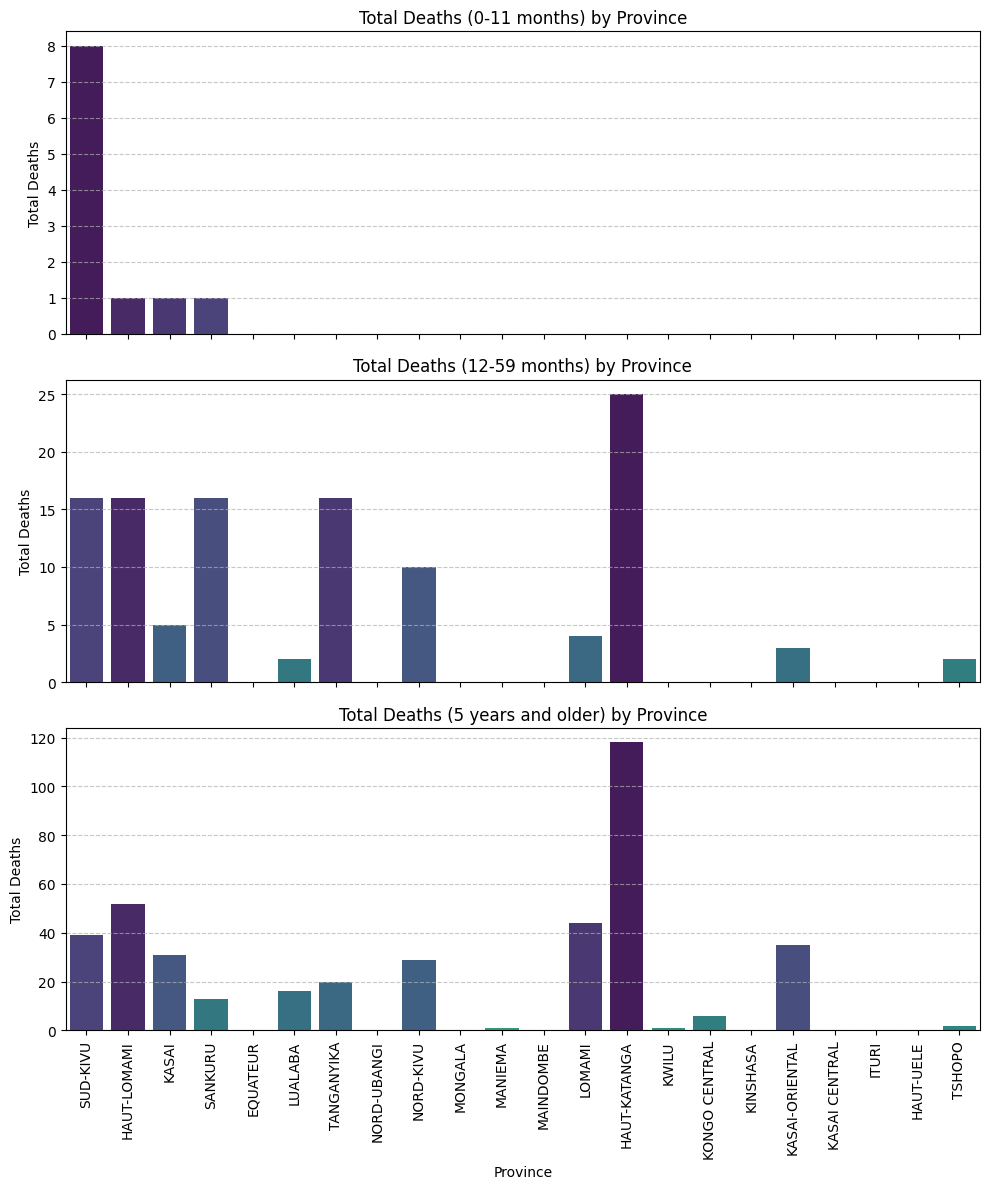

In [113]:
# Total Deaths by Province
# Group data by province for different age groups
df_grouped_prov_0_11 = df.groupby("prov")["d011mois"].sum().sort_values(ascending=False)
df_grouped_prov_12_59 = df.groupby("prov")["d1259mois"].sum().sort_values(ascending=False)
df_grouped_prov_5plus = df.groupby("prov")["d5ansp"].sum().sort_values(ascending=False)
fig, axes = plt.subplots(3, 1, figsize=(10, 12), sharex=True)

# Define categories and titles
categories = [df_grouped_prov_0_11, df_grouped_prov_12_59, df_grouped_prov_5plus]
titles = ["Total Deaths (0-11 months) by Province", "Total Deaths (12-59 months) by Province", "Total Deaths (5 years and older) by Province"]
for i, (data, title) in enumerate(zip(categories, titles)):
    sns.barplot(x=data.index, y=data.values, ax=axes[i], palette="viridis")
    axes[i].set_title(title)
    axes[i].set_ylabel("Total Deaths")
    axes[i].grid(axis="y", linestyle="--", alpha=0.7)  # Add grid lines to the y-axis

# Set x-axis labels only for the last plot
axes[-1].set_xlabel("Province")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

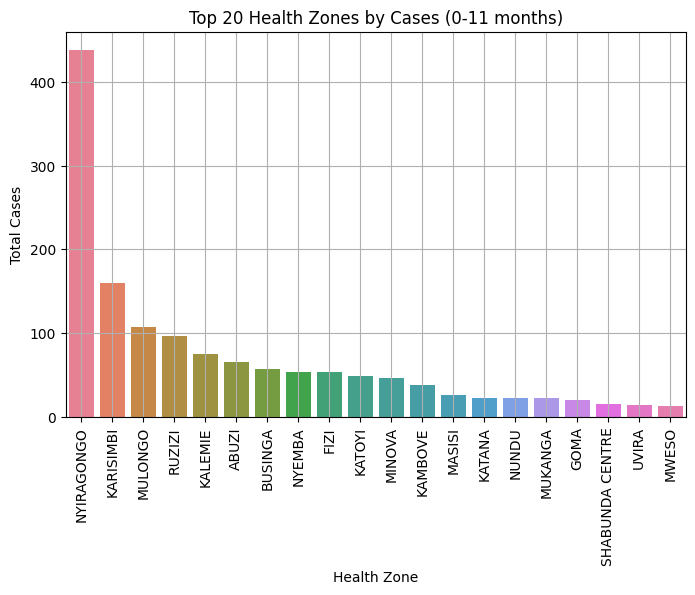

In [114]:
# Disease trends (Cases 0-11 months) per health zone
df_grouped_zs = df.groupby("zs")["c011mois"].sum().sort_values(ascending=False)[:20]  # Top 20 zones
plt.figure(figsize=(8, 5))
sns.barplot(x=df_grouped_zs.index, y=df_grouped_zs.values, palette="husl")
plt.xticks(rotation=90)
plt.title("Top 20 Health Zones by Cases (0-11 months)")
plt.ylabel("Total Cases")
plt.xlabel("Health Zone")
plt.grid()
plt.show()

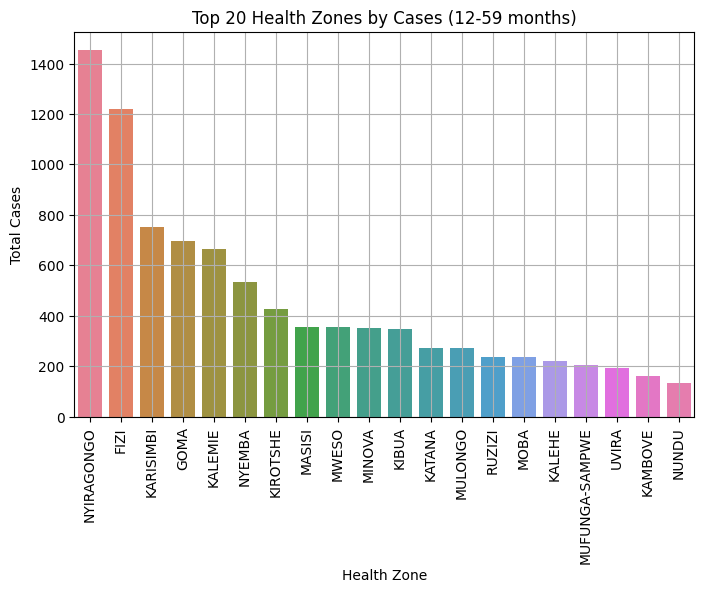

In [115]:
# Disease trends (Cases 12-59 months) per health zone
df_grouped_zs = df.groupby("zs")["c1259mois"].sum().sort_values(ascending=False)[:20]  # Top 20 zones
plt.figure(figsize=(8, 5))
sns.barplot(x=df_grouped_zs.index, y=df_grouped_zs.values, palette="husl")
plt.xticks(rotation=90)
plt.title("Top 20 Health Zones by Cases (12-59 months)")
plt.ylabel("Total Cases")
plt.xlabel("Health Zone")
plt.grid()
plt.show()

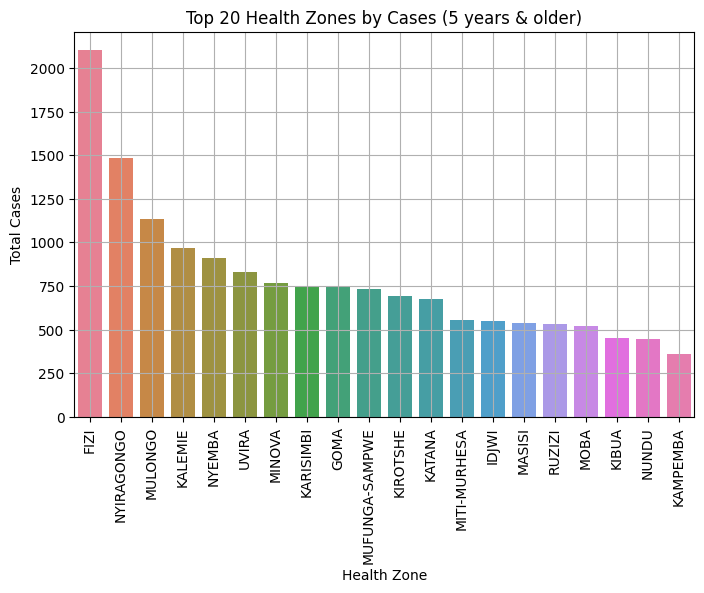

In [116]:
# Disease trends (Cases 5 years & older) per health zone
df_grouped_zs = df.groupby("zs")["c5ansp"].sum().sort_values(ascending=False)[:20]  # Top 20 zones
plt.figure(figsize=(8, 5))
sns.barplot(x=df_grouped_zs.index, y=df_grouped_zs.values, palette="husl")
plt.xticks(rotation=90)
plt.title("Top 20 Health Zones by Cases (5 years & older)")
plt.ylabel("Total Cases")
plt.xlabel("Health Zone")
plt.grid()
plt.show()

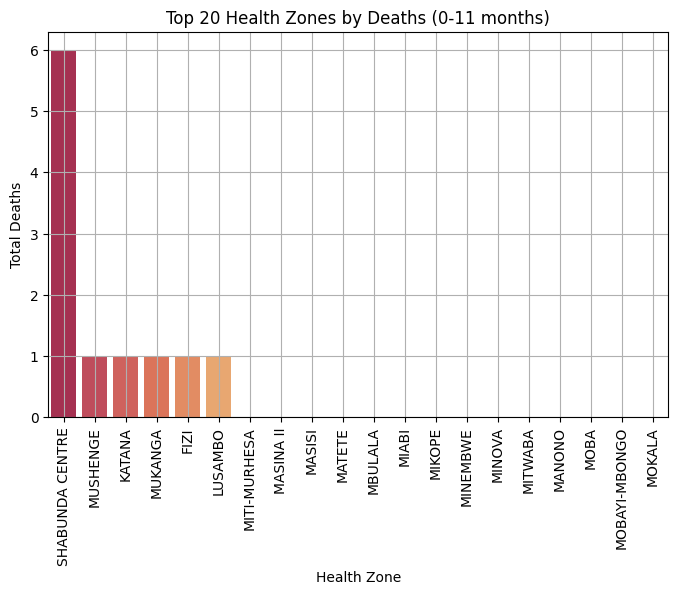

In [117]:
# Disease trends (Deaths 0-11 months) per health zone
df_grouped_zs = df.groupby("zs")["d011mois"].sum().sort_values(ascending=False)[:20]  # Top 20 zones
plt.figure(figsize=(8, 5))
sns.barplot(x=df_grouped_zs.index, y=df_grouped_zs.values, palette="Spectral")
plt.xticks(rotation=90)
plt.title("Top 20 Health Zones by Deaths (0-11 months)")
plt.ylabel("Total Deaths")
plt.xlabel("Health Zone")
plt.grid()
plt.show()

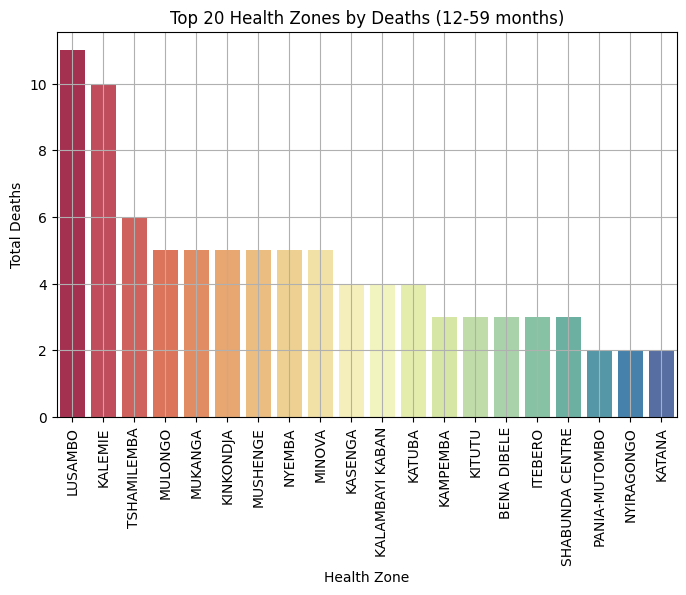

In [118]:
# Disease trends (Deaths 12-59 months) per health zone
df_grouped_zs = df.groupby("zs")["d1259mois"].sum().sort_values(ascending=False)[:20]  # Top 20 zones
plt.figure(figsize=(8, 5))
sns.barplot(x=df_grouped_zs.index, y=df_grouped_zs.values, palette="Spectral")
plt.xticks(rotation=90)
plt.title("Top 20 Health Zones by Deaths (12-59 months)")
plt.ylabel("Total Deaths")
plt.xlabel("Health Zone")
plt.grid()
plt.show()

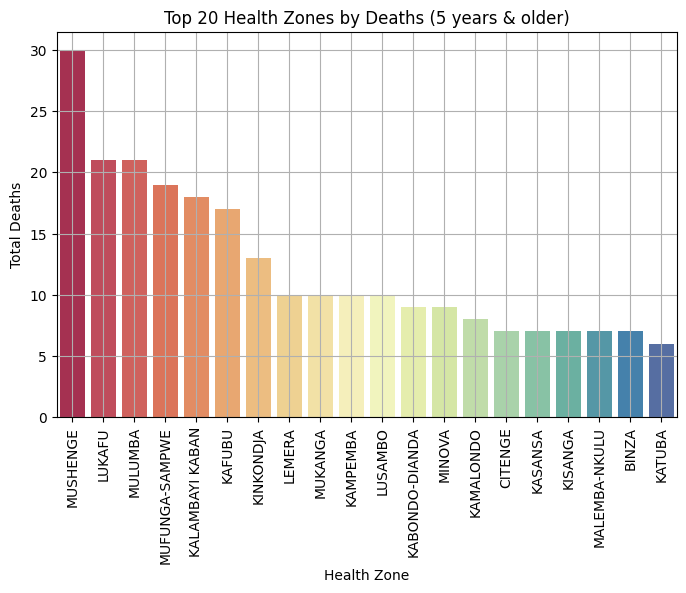

In [119]:
# Disease trends (Deaths 5 years & older) per health zone
df_grouped_zs = df.groupby("zs")["d5ansp"].sum().sort_values(ascending=False)[:20]  # Top 20 zones
plt.figure(figsize=(8, 5))
sns.barplot(x=df_grouped_zs.index, y=df_grouped_zs.values, palette="Spectral")
plt.xticks(rotation=90)
plt.title("Top 20 Health Zones by Deaths (5 years & older)")
plt.ylabel("Total Deaths")
plt.xlabel("Health Zone")
plt.grid()
plt.show()

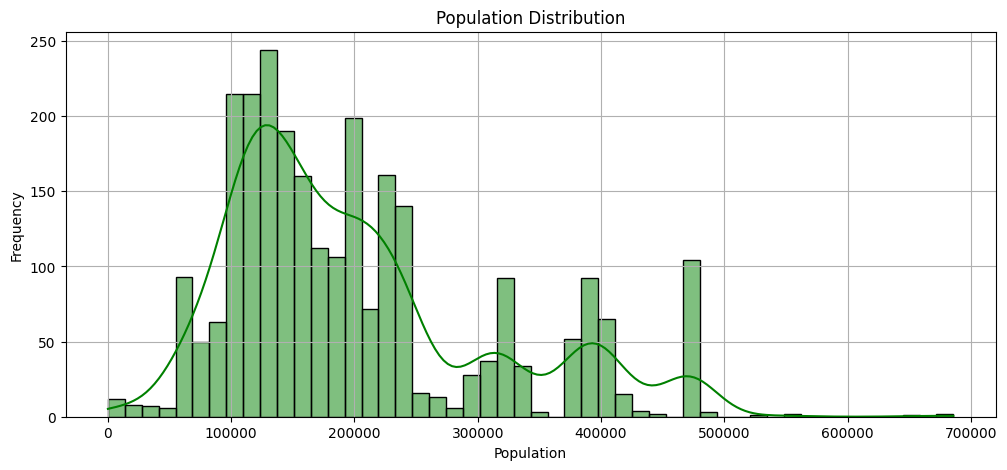

In [120]:
# Population Distribution
plt.figure(figsize=(12, 5))
sns.histplot(df["pop"], bins=50, kde=True, color='green')
plt.title("Population Distribution")
plt.xlabel("Population")
plt.ylabel("Frequency")
plt.grid()
plt.show()

In [121]:
# Drop 2021 data
df = df[df["Annee"] != 2021]

In [122]:
# Handle missing values
df["debutsem"].fillna(method="ffill", inplace=True)
df["pop"].fillna(df["pop"].median(), inplace=True)
# Fill missing cases & deaths with interpolation
case_columns = ["c011mois", "c1259mois", "c5ansp"]
death_columns = ["d011mois", "d1259mois", "d5ansp"]
for col in case_columns + death_columns:
    df[col] = df[col].interpolate(method='linear')  # Time-series interpolation

In [123]:
# Drop duplicates
df.drop_duplicates(inplace=True)
# Fill remaining missing values (if any) with 0
df.fillna(0, inplace=True)

In [124]:
df.to_csv("/content/drive/MyDrive/Colab Notebooks/Time_Series/Disease_ProcessedData.csv", index=False)

In [125]:
# Load the cleaned data
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Time_Series/Disease_ProcessedData.csv')
df.head()

prov              zs       pop    debutsem  c011mois  d011mois  \
0  HAUT-KATANGA          KATUBA  193955.0  2019-12-30       0.0       0.0   
1  HAUT-KATANGA  MUFUNGA-SAMPWE  193955.0  2019-12-30       0.0       0.0   
2  HAUT-KATANGA        MUMBUNDA  193955.0  2019-12-30       0.0       0.0   
3  HAUT-KATANGA           KILWA  193955.0  2019-12-30       0.0       0.0   
4  HAUT-KATANGA       KAMALONDO  193955.0  2019-12-30       0.0       0.0   

   c1259mois  d1259mois  c5ansp  d5ansp  Annee  
0        0.0        0.0     6.0     0.0   2020  
1        1.0        0.0     2.0     0.0   2020  
2        0.0        0.0     1.0     0.0   2020  
3        0.0        0.0     2.0     0.0   2020  
4        0.0        0.0     1.0     0.0   2020

# **Analysis for Cases**

In [126]:
# Aggregate by week
target_columns = ["c011mois", "c1259mois", "c5ansp","d011mois", "d1259mois", "d5ansp"]
df_weekly = df.groupby("debutsem")[target_columns].sum().reset_index()

In [127]:
# Remove Outliers (1st & 99th Percentile)
for col in target_columns:
    q_low, q_high = df_weekly[col].quantile([0.01, 0.99])
    df_weekly[col] = np.clip(df_weekly[col], q_low, q_high)

# **Prophet Model**

In [128]:
# Apply Log Transformation
df_weekly_prophet = df_weekly.copy()
df_weekly_prophet[target_columns] = np.log1p(df_weekly_prophet[target_columns])

In [129]:
# Prophet Forecasting
forecast_Prophet_results = {}
for col in target_columns:
    print(f"Training Prophet for {col}...")
    model_df = df_weekly_prophet[["debutsem", col]].rename(columns={"debutsem": "ds", col: "y"})
    prophet_model = Prophet(seasonality_mode='multiplicative', changepoint_prior_scale=0.3)
    # Add custom seasonalities
    prophet_model.add_seasonality(name='quarterly', period=13, fourier_order=5)
    prophet_model.add_seasonality(name='biweekly', period=14, fourier_order=3)
    prophet_model.add_seasonality(name='monthly', period=30.5, fourier_order=6)
    prophet_model.fit(model_df)
    future = prophet_model.make_future_dataframe(periods=52, freq='W')
    forecast = prophet_model.predict(future)
    forecast["yhat"] = np.expm1(forecast["yhat"])  # Inverse log transformation
    forecast_Prophet_results[f"Prophet_{col}"] = forecast[["ds", "yhat"]]

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqpc3lrmi/6ez9zp6g.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqpc3lrmi/zlxni4z2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84402', 'data', 'file=/tmp/tmpqpc3lrmi/6ez9zp6g.json', 'init=/tmp/tmpqpc3lrmi/zlxni4z2.json', 'output', 'file=/tmp/tmpqpc3lrmi/prophet_modele9ix43i1/prophet_model-20250227175955.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:59:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:59:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Training Prophet for c011mois...


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqpc3lrmi/zh26d78u.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqpc3lrmi/0hof6bx7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94901', 'data', 'file=/tmp/tmpqpc3lrmi/zh26d78u.json', 'init=/tmp/tmpqpc3lrmi/0hof6bx7.json', 'output', 'file=/tmp/tmpqpc3lrmi/prophet_modelxlp3s5sn/prophet_model-20250227175955.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:59:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:59:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Training Prophet for c1259mois...


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqpc3lrmi/btjgq5jq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqpc3lrmi/_plrvm3e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69883', 'data', 'file=/tmp/tmpqpc3lrmi/btjgq5jq.json', 'init=/tmp/tmpqpc3lrmi/_plrvm3e.json', 'output', 'file=/tmp/tmpqpc3lrmi/prophet_model9rh7978b/prophet_model-20250227175955.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:59:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:59:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Training Prophet for c5ansp...
Training Prophet for d011mois...


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqpc3lrmi/7yv9mrjm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqpc3lrmi/qljdw2nb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65457', 'data', 'file=/tmp/tmpqpc3lrmi/7yv9mrjm.json', 'init=/tmp/tmpqpc3lrmi/qljdw2nb.json', 'output', 'file=/tmp/tmpqpc3lrmi/prophet_modelhfkiixhl/prophet_model-20250227175955.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:59:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:59:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqp

Training Prophet for d1259mois...


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqpc3lrmi/g_kefe63.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqpc3lrmi/fh6lury0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60821', 'data', 'file=/tmp/tmpqpc3lrmi/g_kefe63.json', 'init=/tmp/tmpqpc3lrmi/fh6lury0.json', 'output', 'file=/tmp/tmpqpc3lrmi/prophet_model68f_iesj/prophet_model-20250227175956.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:59:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:59:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Training Prophet for d5ansp...


In [130]:
# Rolling Forecast Validation for Prophet Model
for col in target_columns:
    actual = df_weekly_prophet[col].values[-52:]
    predicted = forecast_Prophet_results[f"Prophet_{col}"]["yhat"].values[:52]
    Prophet_r2 = r2_score(actual, predicted)
    Prophet_mae = mean_absolute_error(actual, predicted)
    Prophet_mse = mean_squared_error(actual, predicted)
    Prophet_rmse = np.sqrt(Prophet_mse)
    print(f"Prophet - {col}: R^2={Prophet_r2}, MAE={Prophet_mae}, MSE={Prophet_mse}, RMSE={Prophet_rmse}")

Prophet - c011mois: R^2=-1.0383953891911006, MAE=1.6170808271762842, MSE=5.100147882570825, RMSE=2.2583506996414053
Prophet - c1259mois: R^2=-419.78330947515883, MAE=29.940556575664964, MSE=1809.480130316332, RMSE=42.53798455870155
Prophet - c5ansp: R^2=-1083.3697825345962, MAE=58.622684743319276, MSE=5159.236276147358, RMSE=71.82782382995714
Prophet - d011mois: R^2=0.014819211512676178, MAE=0.050508724042308446, MSE=0.03079946969104375, RMSE=0.17549777688348006
Prophet - d1259mois: R^2=-0.736333383323754, MAE=0.31707448149175643, MSE=0.16142793927803306, RMSE=0.40178095932738406
Prophet - d5ansp: R^2=-14.16067129091408, MAE=1.0238524183864859, MSE=1.6712721246504354, RMSE=1.2927769044388266


In [131]:
# Compute total cases and deaths for 2024 for Prophet Model
forecast_2024 = pd.DataFrame()
forecast_2024["ds"] = pd.date_range(start="2024-01-01", periods=52, freq='W')
forecast = {col: forecast_Prophet_results[f"Prophet_{col}"]["yhat"].values[:52] for col in target_columns}
forecast["casageinc"] = forecast["c011mois"] + forecast["c1259mois"] + forecast["c5ansp"]
forecast["decageinc"] = forecast["d011mois"] + forecast["d1259mois"] + forecast["d5ansp"]
forecast["totalcas"] = forecast["casageinc"]
forecast["totaldeces"] = forecast["decageinc"]
forecast["letal"] = (forecast["totaldeces"] / forecast["totalcas"]) * 100
forecast["attaq"] = (forecast["totalcas"] / df["pop"].sum()) * 100000
forecast_df = pd.DataFrame(forecast)
forecast_df.insert(0, "ds", forecast_2024["ds"])
forecast_Prophet_results["Prophet_2024"] = forecast_df
forecast_df.to_csv("/content/drive/MyDrive/Colab Notebooks/Time_Series/forecast_Prophet_2024.csv", index=False)

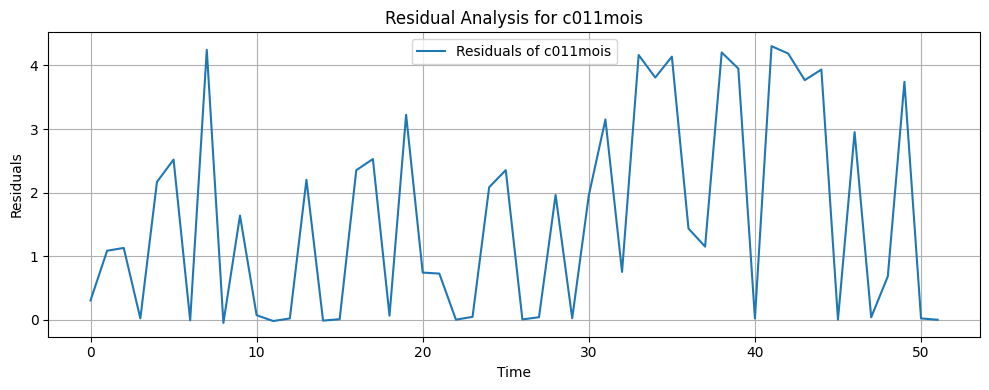

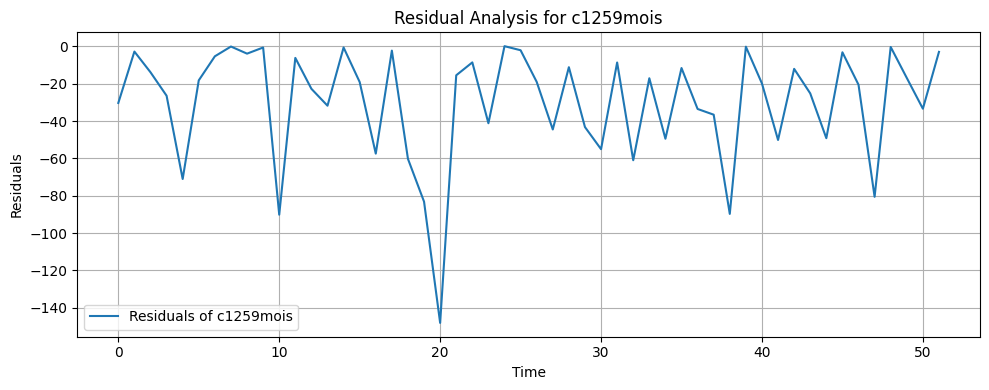

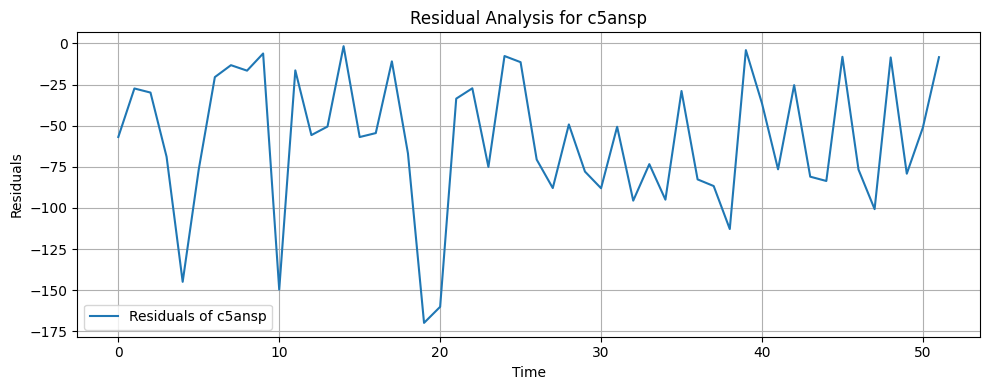

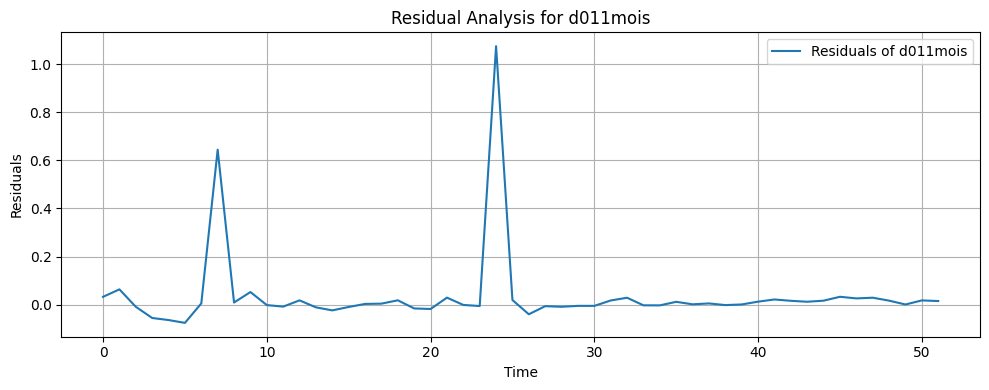

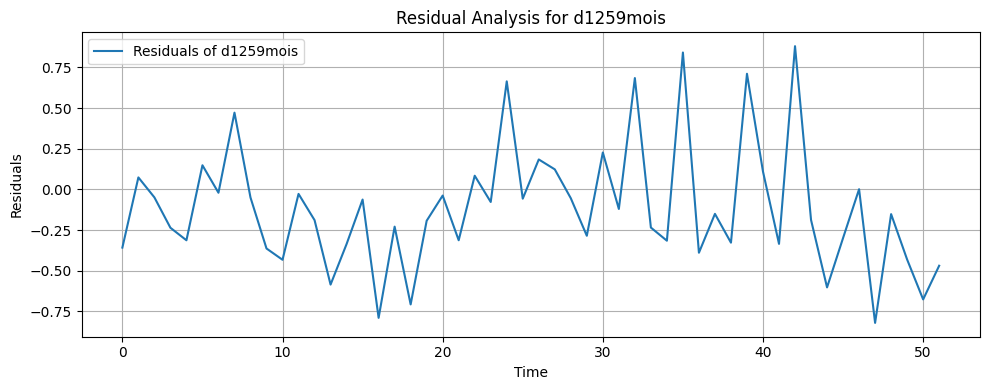

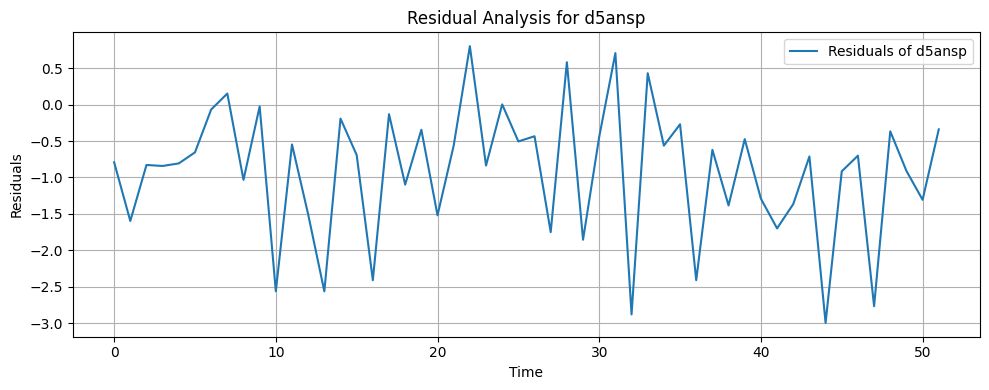

In [132]:
# Residual Analysis for Prophet Model
for col in target_columns:
    actual = df_weekly_prophet[col].values[-52:]
    predicted = forecast_Prophet_results[f"Prophet_{col}"]["yhat"].values[:52]
    residuals = actual - predicted
    plt.figure(figsize=(10, 4))
    plt.plot(residuals, label=f"Residuals of {col}")
    plt.title(f"Residual Analysis for {col}")
    plt.xlabel("Time")
    plt.ylabel("Residuals")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

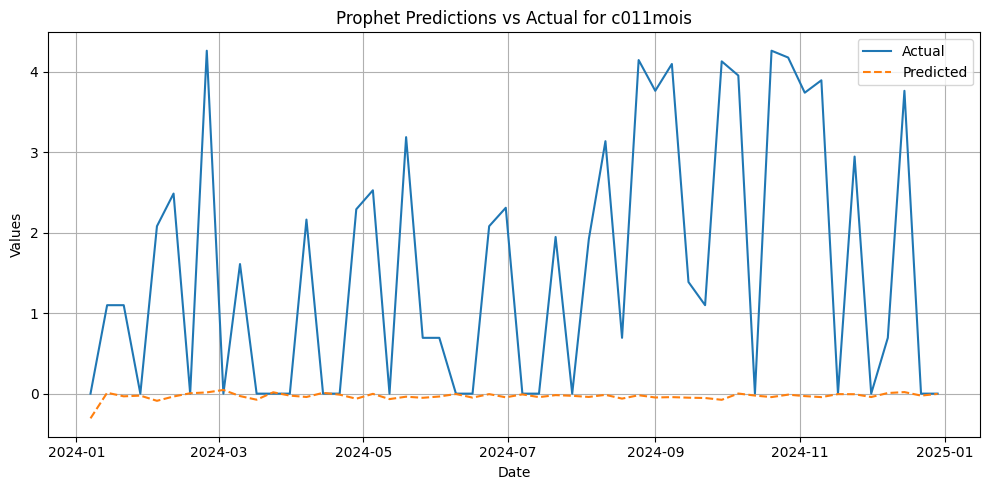

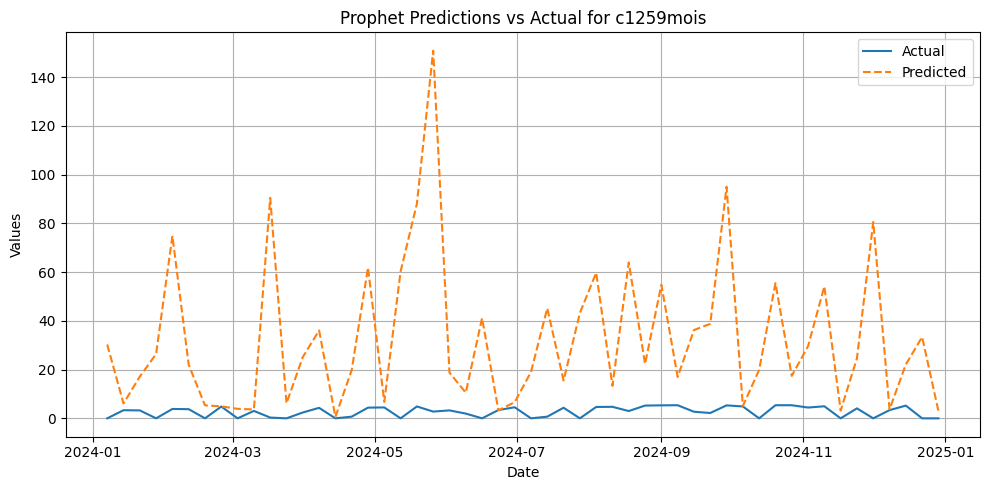

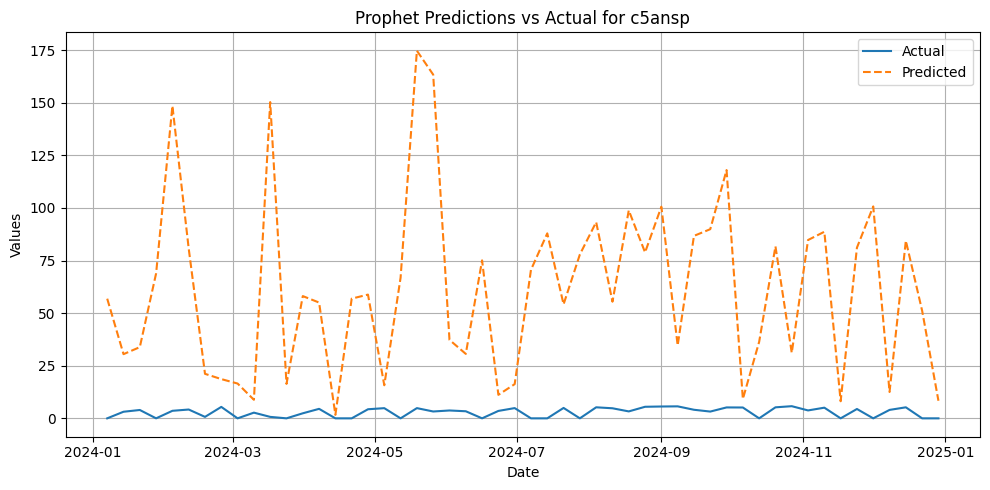

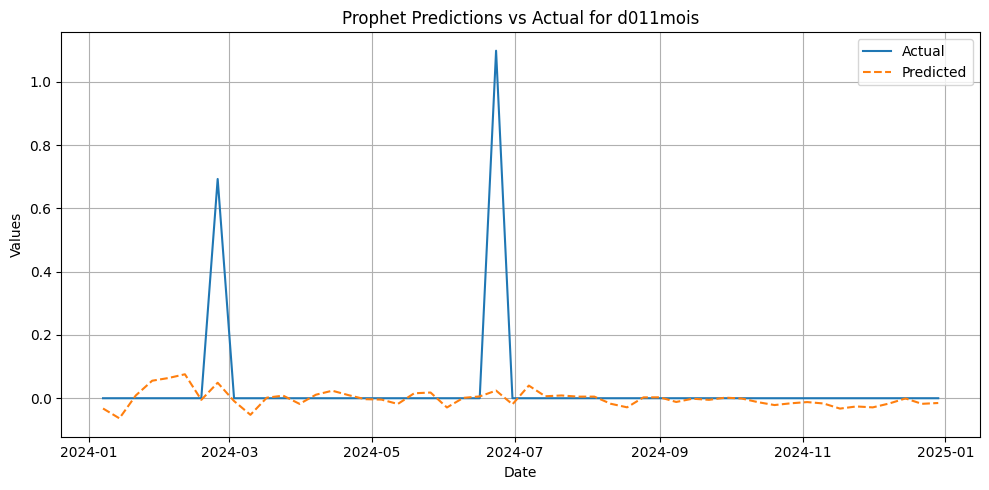

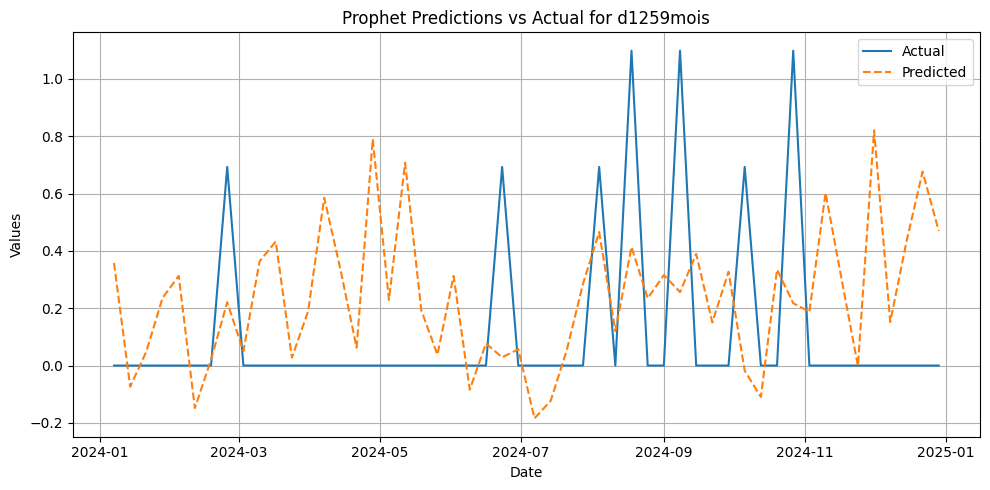

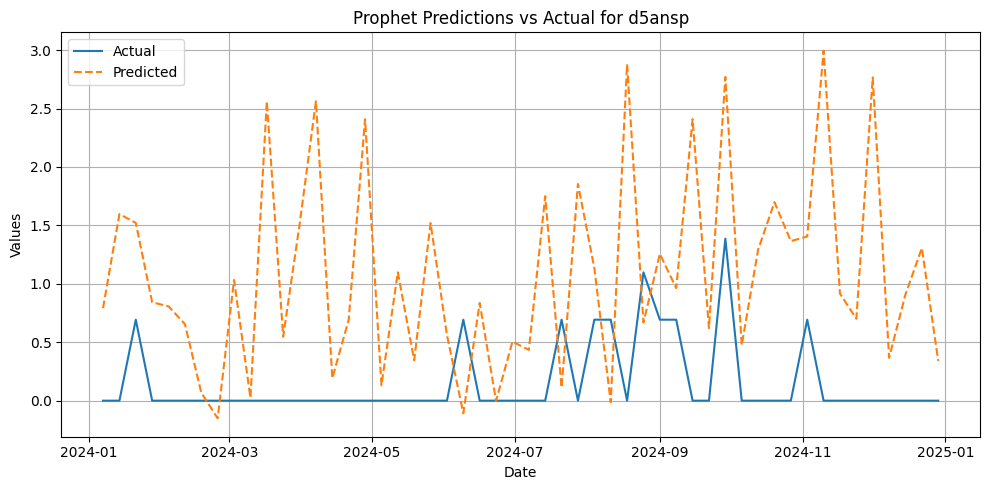

In [133]:
# Actual vs Prediction Plot for Prophet
for col in target_columns:
    actual = df_weekly_prophet[col].values[-52:]
    predicted = forecast_Prophet_results[f"Prophet_{col}"]["yhat"].values[:52]
    plt.figure(figsize=(10,5))
    plt.plot(forecast_Prophet_results["Prophet_2024"]["ds"], actual, label='Actual')
    plt.plot(forecast_Prophet_results["Prophet_2024"]["ds"], predicted, label='Predicted', linestyle='--')
    plt.title(f'Prophet Predictions vs Actual for {col}')
    plt.xlabel('Date')
    plt.ylabel('Values')
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

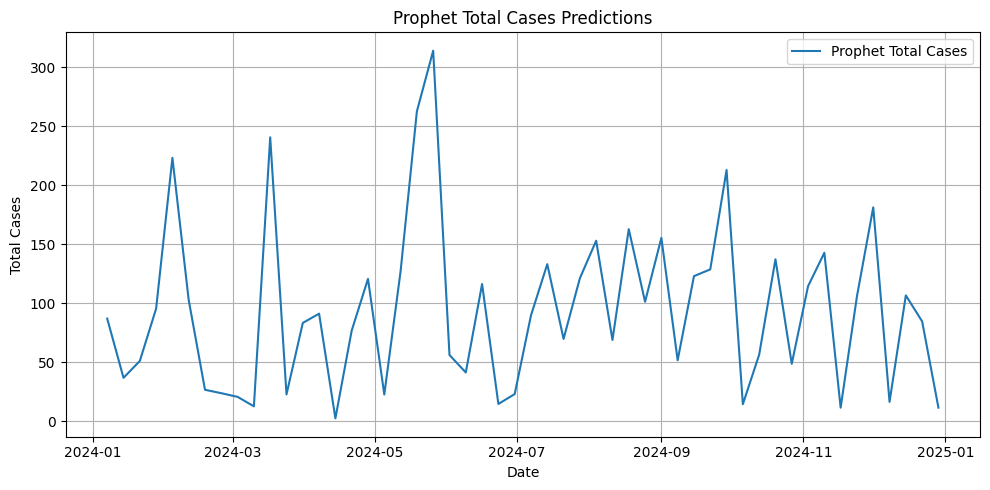

In [134]:
# Plot Prophet total cases
plt.figure(figsize=(10,5))
plt.plot(forecast_Prophet_results["Prophet_2024"]["ds"], forecast_Prophet_results["Prophet_2024"]["totalcas"], label="Prophet Total Cases")
plt.xlabel("Date")
plt.ylabel("Total Cases")
plt.title("Prophet Total Cases Predictions")
plt.legend()
plt.tight_layout()
plt.grid()
plt.show()

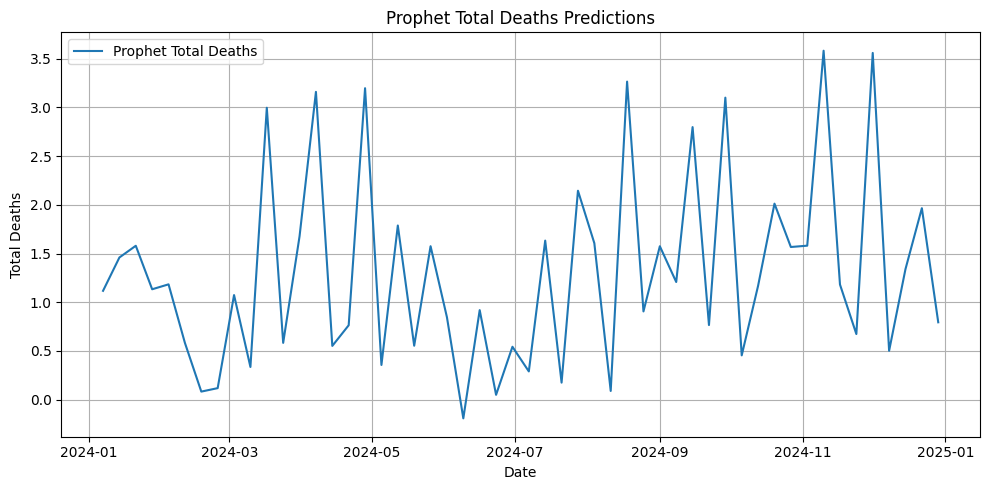

In [135]:
# Plot Prophet total deaths
plt.figure(figsize=(10,5))
plt.plot(forecast_Prophet_results["Prophet_2024"]["ds"], forecast_Prophet_results["Prophet_2024"]["totaldeces"], label="Prophet Total Deaths")
plt.xlabel("Date")
plt.ylabel("Total Deaths")
plt.title("Prophet Total Deaths Predictions")
plt.legend()
plt.tight_layout()
plt.grid()
plt.show()

# **SARIMA Model**

In [136]:
# Check stationarity and apply differencing if needed
for col in target_columns:
    result = adfuller(df_weekly[col])
    p_value = result[1]  # p-value
    if p_value > 0.05:
        df_weekly[col] = df_weekly[col].diff().dropna()

In [137]:
for col in target_columns:
    model_df = df_weekly[["debutsem", col]].rename(columns={"debutsem": "ds", col: "y"})
    model_df.set_index("ds", inplace=True)

    auto_model = pm.auto_arima(model_df["y"], seasonal=True, m=52,  # Weekly seasonality
                               stepwise=True,  trace=True, max_p=2, max_q=2,  # Reduce AR & MA orders
                               max_P=1, max_Q=1,  # Reduce seasonal orders
                               max_d=1, max_D=1,  # Reduce differencing search
                               approximation=True,  n_fits=10,  # Limits number of models tested
                               suppress_warnings=True,  n_jobs=-1)
    print(f"Best SARIMA order for {col}: {auto_model.order}, Seasonal order: {auto_model.seasonal_order}")

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[52] intercept   : AIC=2082.712, Time=5.91 sec
 ARIMA(0,1,0)(0,0,0)[52] intercept   : AIC=2212.243, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[52] intercept   : AIC=2140.256, Time=1.43 sec
 ARIMA(0,1,1)(0,0,1)[52] intercept   : AIC=2076.224, Time=1.72 sec
 ARIMA(0,1,0)(0,0,0)[52]             : AIC=2210.243, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[52] intercept   : AIC=2074.292, Time=0.17 sec
 ARIMA(0,1,1)(1,0,0)[52] intercept   : AIC=2076.220, Time=3.60 sec
 ARIMA(0,1,1)(1,0,1)[52] intercept   : AIC=2078.164, Time=3.44 sec
 ARIMA(1,1,1)(0,0,0)[52] intercept   : AIC=2076.291, Time=0.13 sec
 ARIMA(0,1,2)(0,0,0)[52] intercept   : AIC=2076.291, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[52] intercept   : AIC=2138.726, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[52] intercept   : AIC=2077.631, Time=0.18 sec
 ARIMA(0,1,1)(0,0,0)[52]             : AIC=2072.586, Time=0.04 sec
 ARIMA(0,1,1)(1,0,0)[52]             : AIC=2074.522, Time=0.73 sec
 ARIMA(0,1,1)(0,0,1

In [138]:
df_weekly_sarima = df_weekly.copy()
scaler = MinMaxScaler()
df_weekly_sarima[target_columns] = scaler.fit_transform(df_weekly_sarima[target_columns])  # MinMax Scaling

In [139]:
# SARIMA Forecasting
# Define best SARIMA orders from auto_arima results
best_sarima_orders = {"c011mois": ((0,1,1), (0,1,0,52)), "c1259mois": ((1,0,1), (0,1,0,52)), "c5ansp": ((0,1,2), (0,1,1,52)),
                      "d011mois": ((2,1,1), (0,1,0,52)), "d1259mois": ((1,0,0), (0,1,0,52)), "d5ansp": ((2,1,1), (0,1,0,52))}
forecast_sarima_results = {}

for col in target_columns:
    print(f"Training SARIMA for {col}...")
    model_df = df_weekly_sarima[["debutsem", col]].rename(columns={"debutsem": "ds", col: "y"})
    model_df.set_index("ds", inplace=True)
    order, seasonal_order = best_sarima_orders[col]
    # Fit SARIMA model with best parameters
    sarima_model = SARIMAX(model_df["y"], order=order, seasonal_order=seasonal_order, enforce_stationarity=False, enforce_invertibility=False)
    sarima_result = sarima_model.fit()
    forecast = sarima_result.get_forecast(steps=52)
    # Access predicted values using .predicted_mean
    forecast_df = forecast.conf_int()
    forecast_df["yhat"] = forecast.predicted_mean # Store the forecasted values without inverse log transformation
    forecast_df["ds"] = forecast_df.index #Store the corresponding dates

    # Reshape 'yhat' to a 2D array for inverse_transform
    yhat_values = forecast_df["yhat"].values.reshape(-1, 1)

    # Fit a new scaler for each column to avoid shape issues
    scaler = MinMaxScaler()
    scaler.fit(df_weekly_sarima[[col]]) # Fit on the specific column only

    forecast_df["yhat"] = scaler.inverse_transform(yhat_values)[:, 0]
    forecast_sarima_results[f"SARIMA_{col}"] = forecast_df[["ds", "yhat"]]

Training SARIMA for c011mois...
Training SARIMA for c1259mois...
Training SARIMA for c5ansp...
Training SARIMA for d011mois...
Training SARIMA for d1259mois...
Training SARIMA for d5ansp...


In [140]:
# Rolling Forecast Validation for SARIMA Model
for col in target_columns:
    actual = df_weekly_sarima[col].values[-52:]
    predicted = forecast_sarima_results[f"SARIMA_{col}"]["yhat"].values[:52]
    SARIMA_r2 = r2_score(actual, predicted)
    SARIMA_mae = mean_absolute_error(actual, predicted)
    SARIMA_mse = mean_squared_error(actual, predicted)
    SARIMA_rmse = np.sqrt(SARIMA_mse)
    print(f"SARIMA - {col}: R^2={SARIMA_r2}, MAE={SARIMA_mae}, MSE={SARIMA_mse}, RMSE={SARIMA_rmse}")

SARIMA - c011mois: R^2=0.6237910016584769, MAE=0.19587443968061338, MSE=0.03836679612019425, RMSE=0.19587443968061338
SARIMA - c1259mois: R^2=0.9514417251324032, MAE=0.060437927504361014, MSE=0.0052456846981106895, RMSE=0.07242709919712849
SARIMA - c5ansp: R^2=0.2228917589142705, MAE=0.20719466609947915, MSE=0.05934514152498063, RMSE=0.24360858261765048
SARIMA - d011mois: R^2=0.3664513050351692, MAE=0.12119793422468914, MSE=0.014702359692693468, RMSE=0.12125328734798685
SARIMA - d1259mois: R^2=1.0, MAE=1.1194753990700328e-17, MSE=9.522000608534388e-34, RMSE=3.085773907552915e-17
SARIMA - d5ansp: R^2=0.04603234154699165, MAE=0.05851495774055872, MSE=0.003425464206249108, RMSE=0.05852746540086208


In [141]:
# Compute total cases and deaths for 2024 for SARIMA Model
forecast_2024 = pd.DataFrame()
forecast_2024["ds"] = pd.date_range(start="2024-01-01", periods=52, freq='W')
forecast = {col: forecast_sarima_results[f"SARIMA_{col}"]["yhat"].values[:52] for col in target_columns}
forecast["casageinc"] = forecast["c011mois"] + forecast["c1259mois"] + forecast["c5ansp"]
forecast["decageinc"] = forecast["d011mois"] + forecast["d1259mois"] + forecast["d5ansp"]
forecast["totalcas"] = forecast["casageinc"]
forecast["totaldeces"] = forecast["decageinc"]
forecast["letal"] = (forecast["totaldeces"] / forecast["totalcas"]) * 100
forecast["attaq"] = (forecast["totalcas"] / df["pop"].sum()) * 100000
forecast_df = pd.DataFrame(forecast)
forecast_df.insert(0, "ds", forecast_2024["ds"])
forecast_sarima_results["SARIMA_2024"] = forecast_df
forecast_df.to_csv("/content/drive/MyDrive/Colab Notebooks/Time_Series/forecast_SARIMA_2024.csv", index=False)

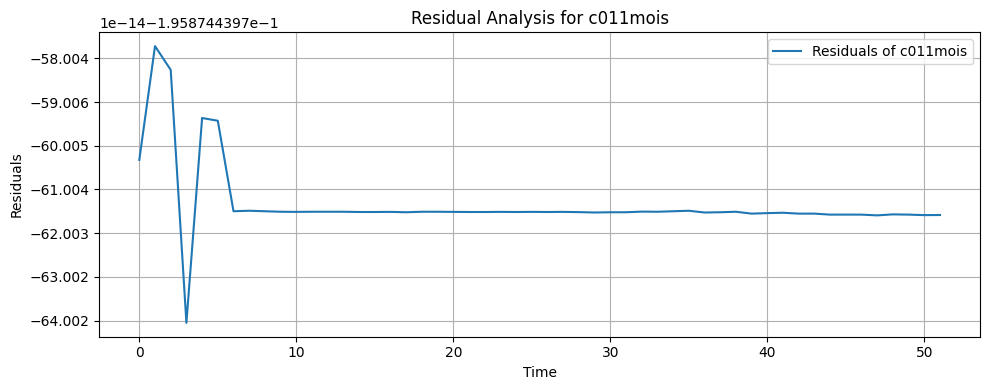

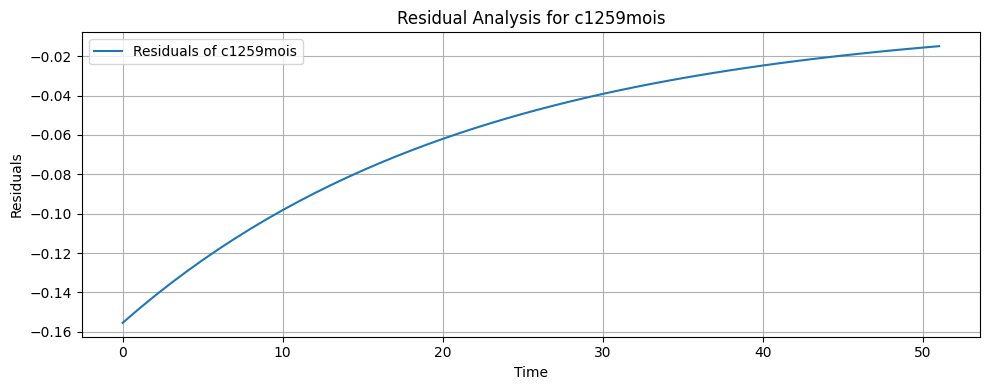

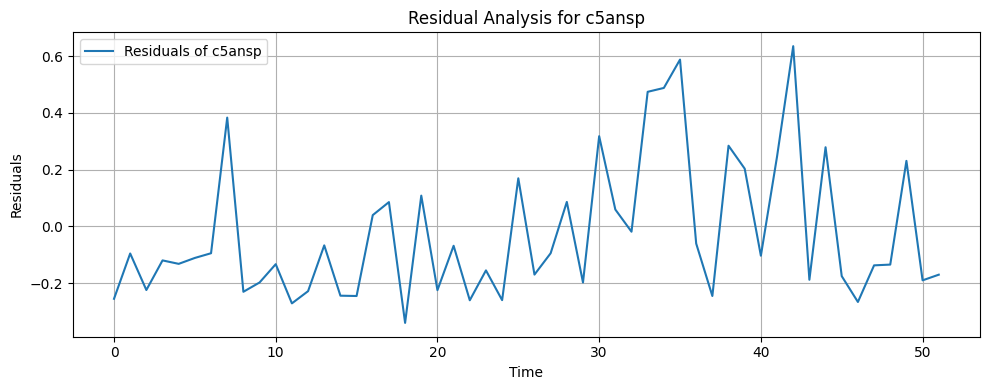

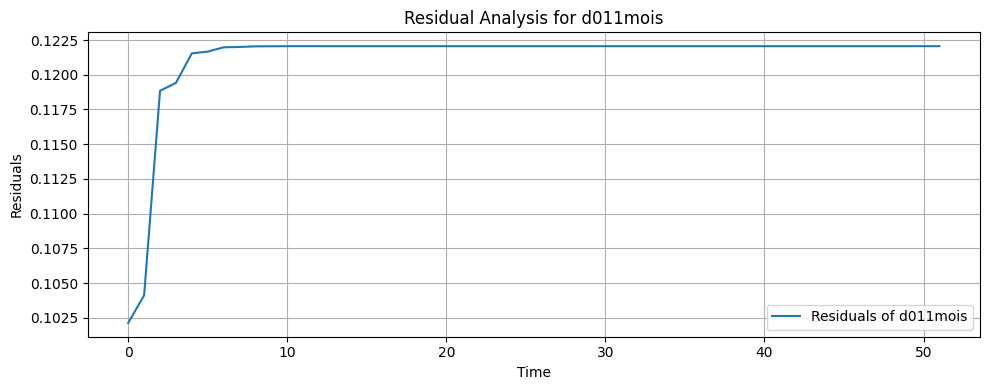

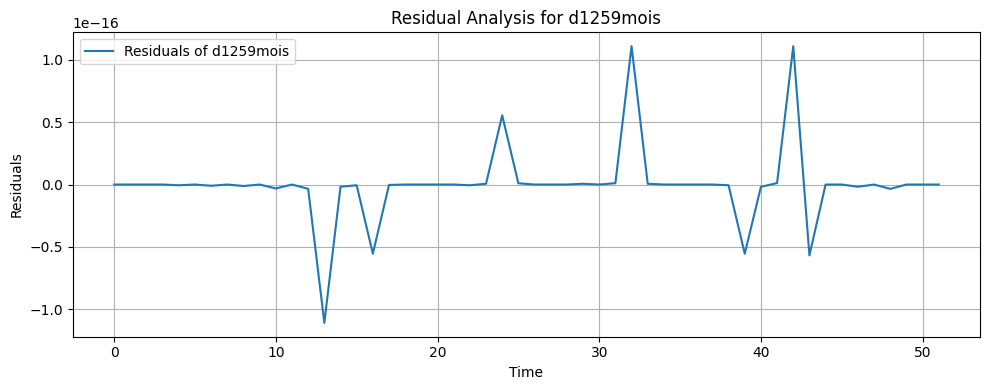

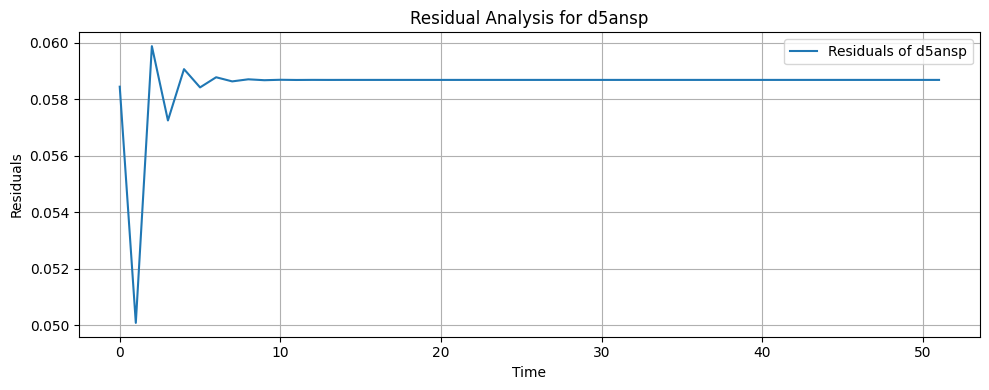

In [142]:
# Residual Analysis for SARIMA Model
for col in target_columns:
    actual = df_weekly_sarima[col].values[-52:]
    predicted = forecast_sarima_results[f"SARIMA_{col}"]["yhat"].values[:52]
    residuals = actual - predicted
    plt.figure(figsize=(10, 4))
    plt.plot(residuals, label=f"Residuals of {col}")
    plt.title(f"Residual Analysis for {col}")
    plt.xlabel("Time")
    plt.ylabel("Residuals")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

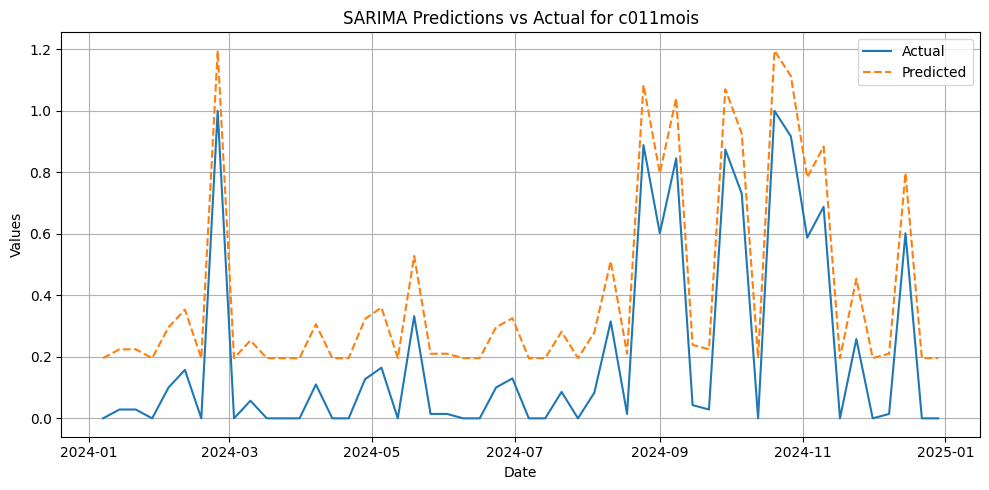

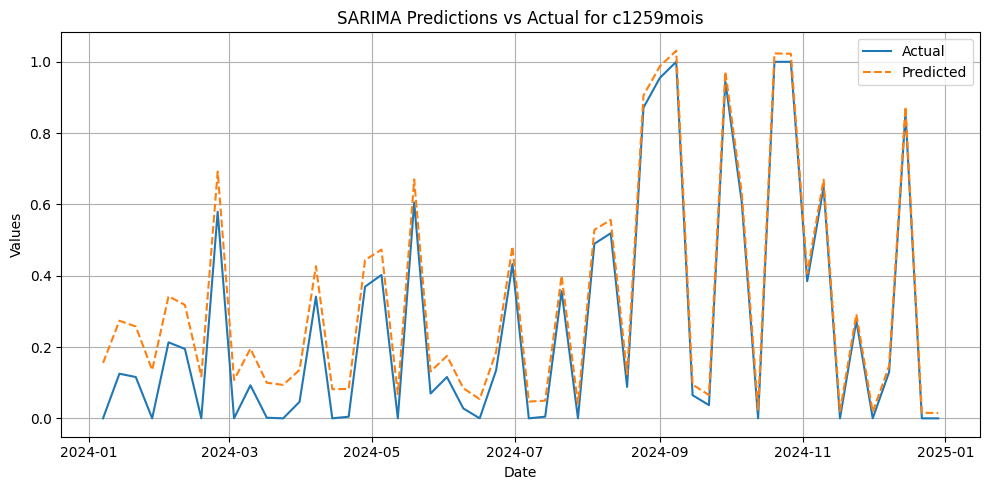

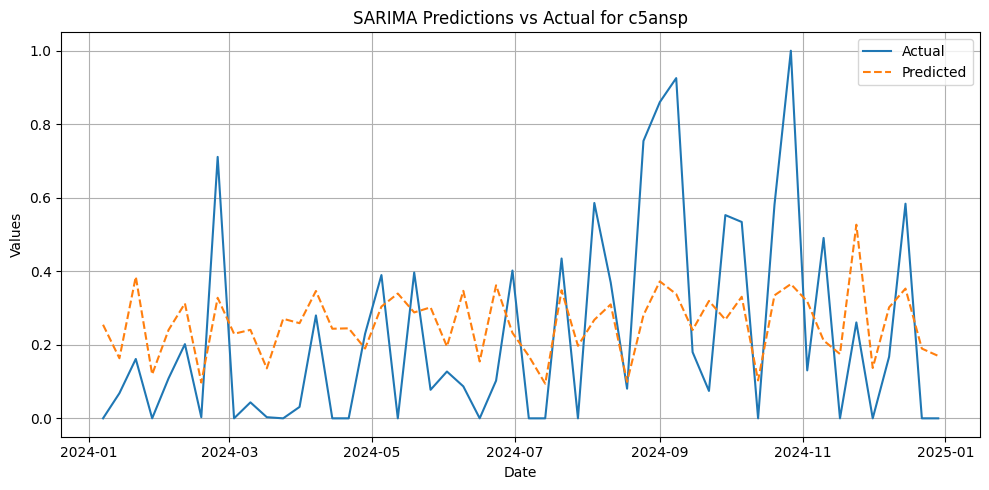

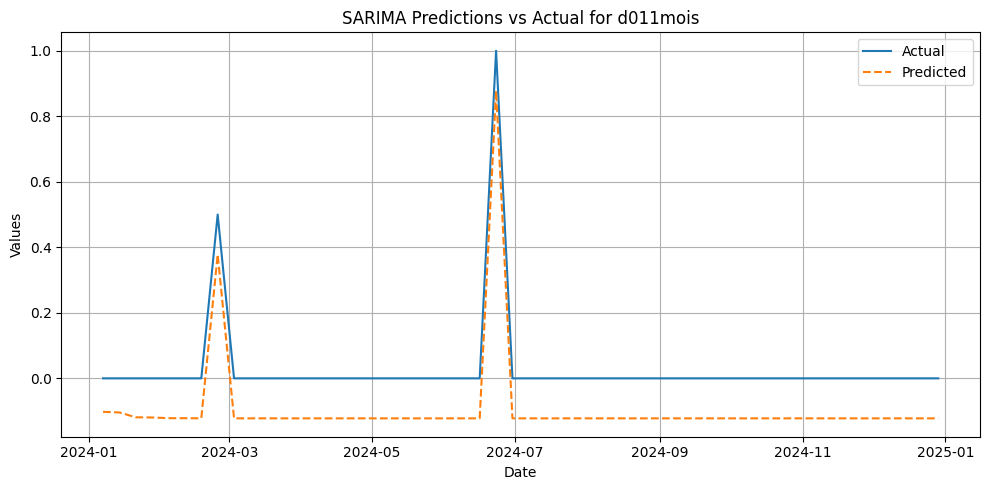

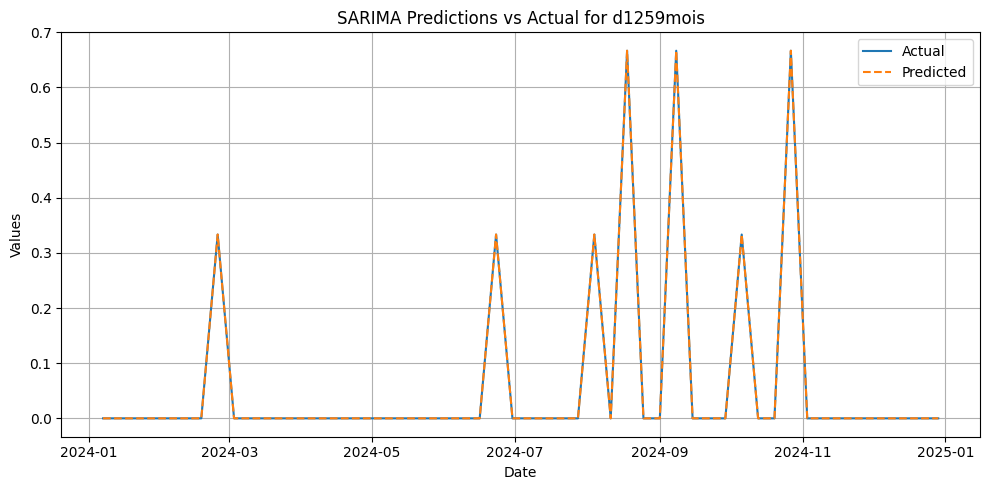

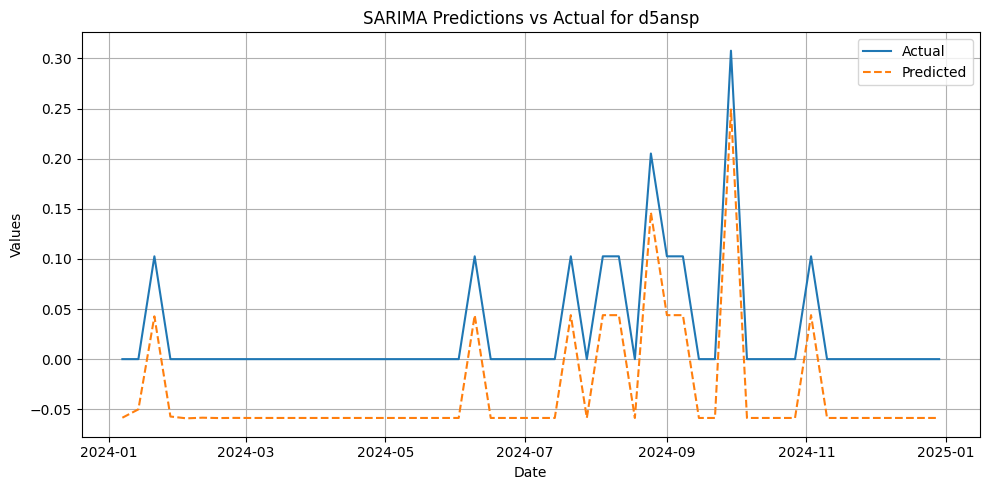

In [143]:
# Actual vs Prediction Plot for SARIMA
for col in target_columns:
    actual = df_weekly_sarima[col].values[-52:]
    predicted = forecast_sarima_results[f"SARIMA_{col}"]["yhat"].values[:52]
    plt.figure(figsize=(10,5))
    plt.plot(forecast_sarima_results["SARIMA_2024"]["ds"], actual, label='Actual')
    plt.plot(forecast_sarima_results["SARIMA_2024"]["ds"], predicted, label='Predicted', linestyle='--')
    plt.title(f'SARIMA Predictions vs Actual for {col}')
    plt.xlabel('Date')
    plt.ylabel('Values')
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

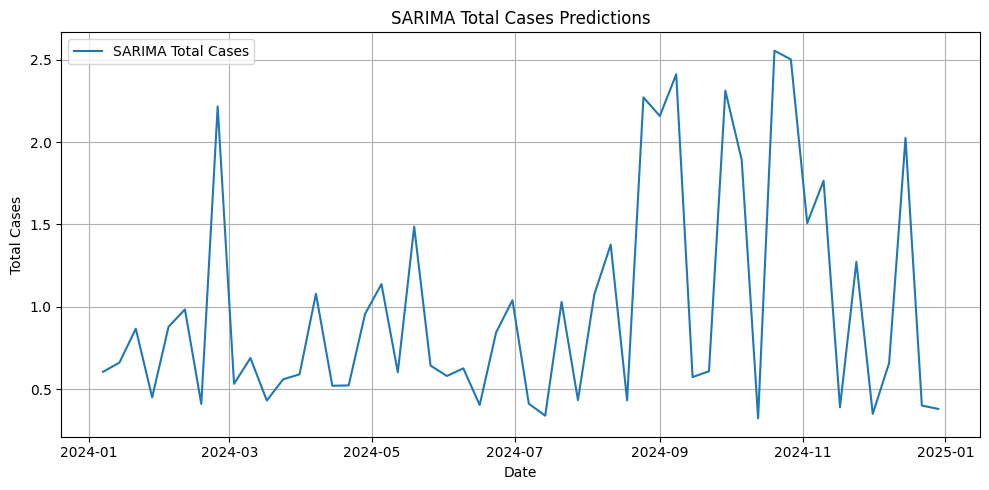

In [144]:
# Plot SARIMA total cases
plt.figure(figsize=(10,5))
plt.plot(forecast_sarima_results["SARIMA_2024"]["ds"], forecast_sarima_results["SARIMA_2024"]["totalcas"], label="SARIMA Total Cases")
plt.xlabel("Date")
plt.ylabel("Total Cases")
plt.title("SARIMA Total Cases Predictions")
plt.legend()
plt.tight_layout()
plt.grid()
plt.show()

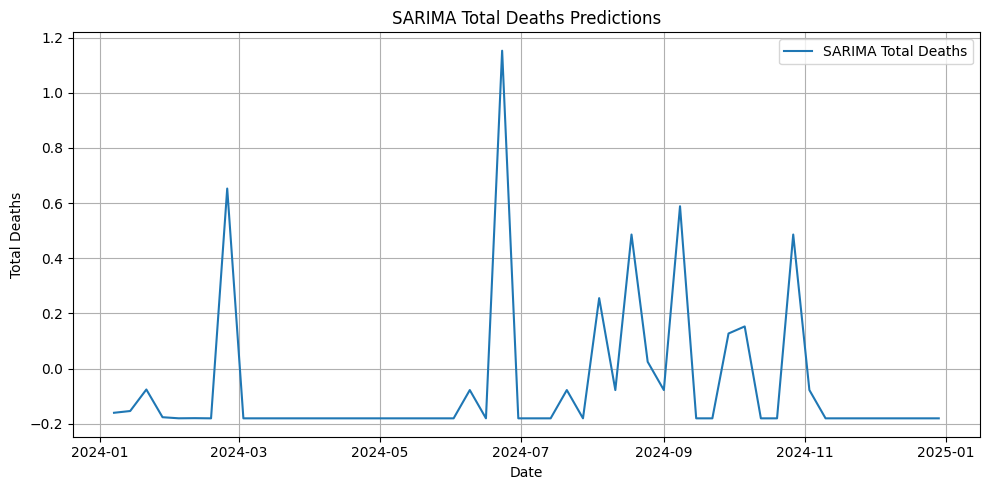

In [145]:
# Plot SARIMA total deaths
plt.figure(figsize=(10,5))
plt.plot(forecast_sarima_results["SARIMA_2024"]["ds"], forecast_sarima_results["SARIMA_2024"]["totaldeces"], label="SARIMA Total Deaths")
plt.xlabel("Date")
plt.ylabel("Total Deaths")
plt.title("SARIMA Total Deaths Predictions")
plt.legend()
plt.tight_layout()
plt.grid()
plt.show()

# **ARIMA Model**

In [178]:
from statsmodels.tsa.stattools import adfuller
for col in target_columns:
    result = adfuller(df_weekly[col])
    print(f"{col}: ADF Statistic = {result[0]}, p-value = {result[1]}")

c011mois: ADF Statistic = -3.7217501351401556, p-value = 0.0038174147764179632
c1259mois: ADF Statistic = -3.4265666592127904, p-value = 0.01008587547835625
c5ansp: ADF Statistic = -3.386824638044373, p-value = 0.011416303110549694
d011mois: ADF Statistic = -5.083503113167968, p-value = 1.5130249471621022e-05
d1259mois: ADF Statistic = -11.501957308325482, p-value = 4.469298990584057e-21
d5ansp: ADF Statistic = -3.5218098487950376, p-value = 0.007444322599701722


In [182]:
# Apply Scaling
df_weekly_arima = df_weekly.copy()
scaler = MinMaxScaler()
df_weekly_arima[target_columns] = scaler.fit_transform(df_weekly_arima[target_columns])

In [171]:
for col in target_columns:
    model_df = df_weekly[["debutsem", col]].rename(columns={"debutsem": "ds", col: "y"}).set_index("ds")
    auto_model = pm.auto_arima(model_df["y"], seasonal=True, m=52, stepwise=True, suppress_warnings=True, trace=True)
    print(f"Best ARIMA order for {col}: {auto_model.order}, Seasonal Order: {auto_model.seasonal_order}")

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[52] intercept   : AIC=2082.712, Time=8.30 sec
 ARIMA(0,1,0)(0,0,0)[52] intercept   : AIC=2212.243, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[52] intercept   : AIC=2140.256, Time=1.39 sec
 ARIMA(0,1,1)(0,0,1)[52] intercept   : AIC=2076.224, Time=1.63 sec
 ARIMA(0,1,0)(0,0,0)[52]             : AIC=2210.243, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[52] intercept   : AIC=2074.292, Time=0.08 sec
 ARIMA(0,1,1)(1,0,0)[52] intercept   : AIC=2076.220, Time=1.69 sec
 ARIMA(0,1,1)(1,0,1)[52] intercept   : AIC=2078.164, Time=5.43 sec
 ARIMA(1,1,1)(0,0,0)[52] intercept   : AIC=2076.291, Time=0.11 sec
 ARIMA(0,1,2)(0,0,0)[52] intercept   : AIC=2076.291, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[52] intercept   : AIC=2138.726, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[52] intercept   : AIC=2077.631, Time=0.17 sec
 ARIMA(0,1,1)(0,0,0)[52]             : AIC=2072.586, Time=0.05 sec
 ARIMA(0,1,1)(1,0,0)[52]             : AIC=2074.522, Time=0.72 sec
 ARIMA(0,1,1)(0,0,1

In [183]:
# ARIMA Forecasting
best_arima_orders = {"c011mois": ((0,1,1), (0,0,0,52)), "c1259mois": ((3,0,1), (0,0,0,52)), "c5ansp": ((0,1,2), (0,0,1,52)),
                      "d011mois": ((2,1,1), (0,0,0,52)), "d1259mois": ((1,0,0), (0,0,0,52)), "d5ansp": ((2,1,1), (0,0,1,52))}
forecast_arima_results = {}

for col in target_columns:
    print(f"Training ARIMA for {col}...")
    model_df = df_weekly_arima[["debutsem", col]].rename(columns={"debutsem": "ds", col: "y"})
    model_df.set_index("ds", inplace=True)

    # Retrieve the best order for ARIMA from predefined dictionary
    best_order, seasonal_order = best_arima_orders[col]
    arima_model = ARIMA(model_df["y"], order=best_order)
    arima_result = arima_model.fit()

    # Generate Forecast
    forecast = arima_result.get_forecast(steps=52)
    forecast_df = forecast.conf_int()
    forecast_df["yhat"] = forecast.predicted_mean  # No log transformation needed
    forecast_arima_results[f"ARIMA_{col}"] = forecast_df[["yhat"]]
    forecast_arima_results[f"ARIMA_{col}"]["ds"] = forecast_df.index

    scaler_col = MinMaxScaler()
    scaler_col.fit(df_weekly_arima[[col]])  # Fit on original column
    forecast_arima_results[f"ARIMA_{col}"]["yhat"] = scaler_col.inverse_transform(forecast_arima_results[f"ARIMA_{col}"]["yhat"].values.reshape(-1, 1))

Training ARIMA for c011mois...
Training ARIMA for c1259mois...
Training ARIMA for c5ansp...
Training ARIMA for d011mois...
Training ARIMA for d1259mois...
Training ARIMA for d5ansp...


In [184]:
# Rolling Forecast Validation for ARIMA Model
for col in target_columns:
    actual = df_weekly_arima[col].values[-52:]
    predicted = forecast_arima_results[f"ARIMA_{col}"]["yhat"].values[:52]
    ARIMA_r2 = r2_score(actual, predicted)
    ARIMA_mae = mean_absolute_error(actual, predicted)
    ARIMA_mse = mean_squared_error(actual, predicted)
    ARIMA_rmse = np.sqrt(ARIMA_mse)
    print(f"ARIMA - {col}: R^2={ARIMA_r2}, MAE={ARIMA_mae}, MSE={ARIMA_mse}, RMSE={ARIMA_rmse}")

ARIMA - c011mois: R^2=-0.005983371390873238, MAE=0.26896714651544446, MSE=0.10259286481877675, RMSE=0.32030120951812957
ARIMA - c1259mois: R^2=-0.11231937041339357, MAE=0.26165643962513385, MSE=0.12016235578178043, RMSE=0.346644422689563
ARIMA - c5ansp: R^2=-0.013711942987921777, MAE=0.23752730505608177, MSE=0.07741377010508974, RMSE=0.2782333015745774
ARIMA - d011mois: R^2=-0.003921165866694443, MAE=0.06515074580822053, MSE=0.023297356937180137, RMSE=0.15263471733907766
ARIMA - d1259mois: R^2=-0.07443732669184411, MAE=0.14534817551846343, MSE=0.03231788803165803, RMSE=0.17977176650313595
ARIMA - d5ansp: R^2=-0.012708477160816356, MAE=0.045923404636584134, MSE=0.0036363880988427646, RMSE=0.06030247174737338


In [185]:
# Compute total cases and deaths for 2024 for ARIMA Model
forecast_2024 = pd.DataFrame()
forecast_2024["ds"] = pd.date_range(start="2024-01-01", periods=52, freq='W')
forecast = {col: forecast_arima_results[f"ARIMA_{col}"]["yhat"].values[:52] for col in target_columns}
forecast["casageinc"] = forecast["c011mois"] + forecast["c1259mois"] + forecast["c5ansp"]
forecast["decageinc"] = forecast["d011mois"] + forecast["d1259mois"] + forecast["d5ansp"]
forecast["totalcas"] = forecast["casageinc"]
forecast["totaldeces"] = forecast["decageinc"]
forecast["letal"] = (forecast["totaldeces"] / forecast["totalcas"]) * 100
forecast["attaq"] = (forecast["totalcas"] / df["pop"].sum()) * 100000
forecast_df = pd.DataFrame(forecast)
forecast_df.insert(0, "ds", forecast_2024["ds"])
forecast_arima_results["ARIMA_2024"] = forecast_df
forecast_df.to_csv("/content/drive/MyDrive/Colab Notebooks/Time_Series/forecast_ARIMA_2024.csv", index=False)

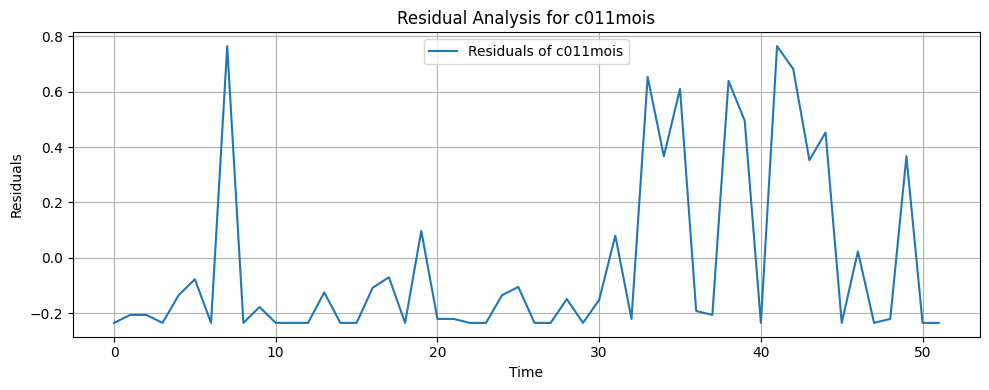

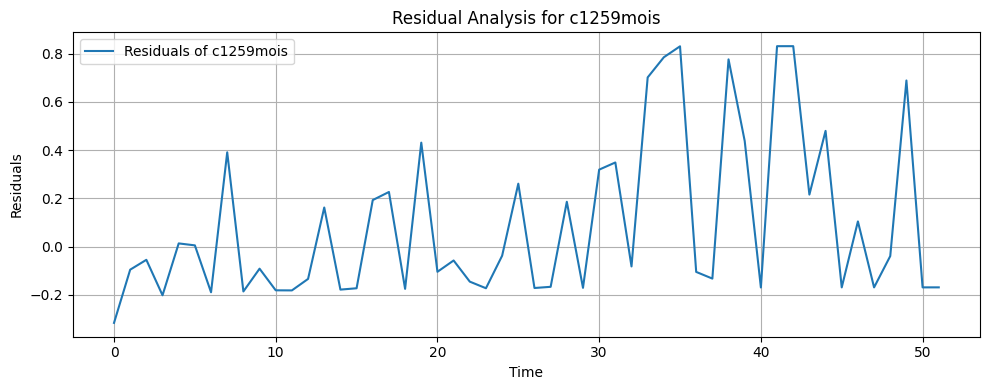

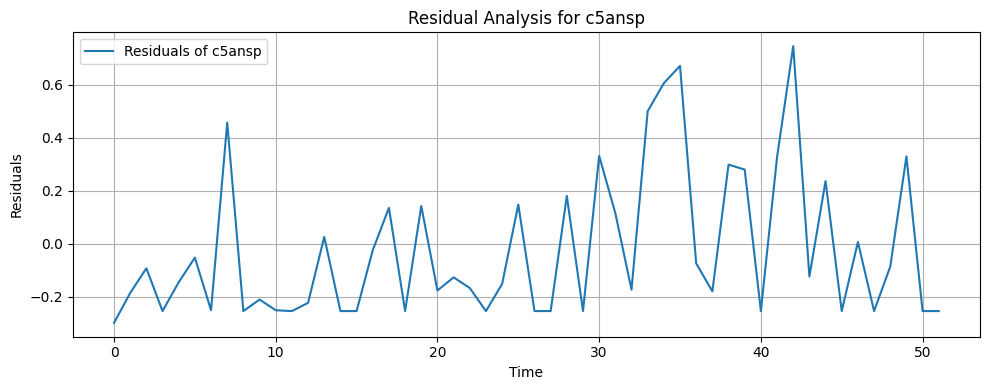

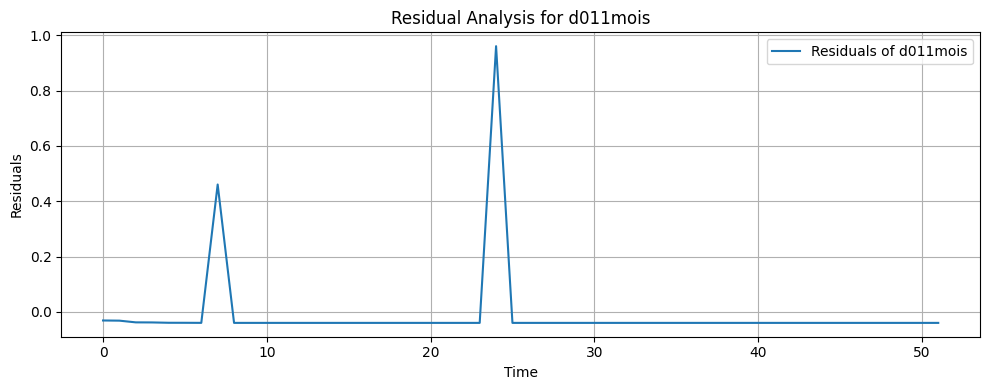

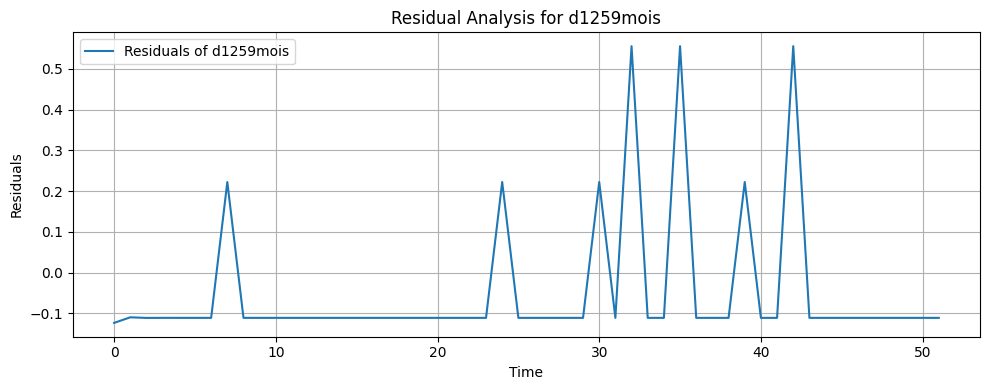

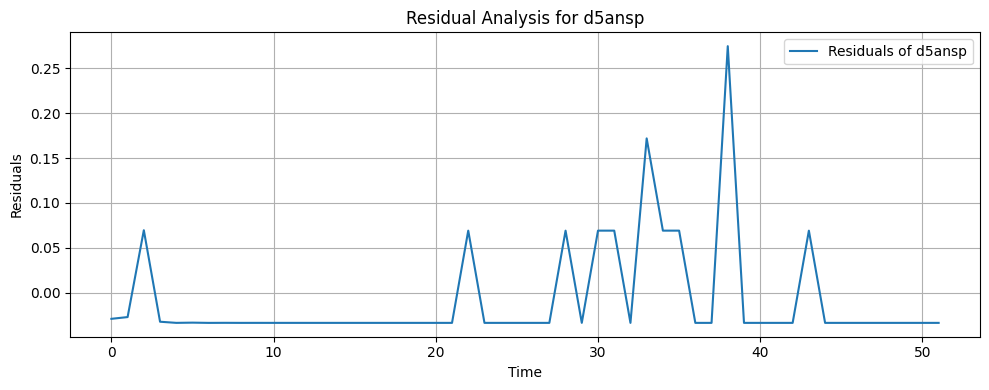

In [186]:
# Residual Analysis for ARIMA Model
for col in target_columns:
    actual = df_weekly_arima[col].values[-52:]
    predicted = forecast_arima_results[f"ARIMA_{col}"]["yhat"].values[:52]
    residuals = actual - predicted
    plt.figure(figsize=(10, 4))
    plt.plot(residuals, label=f"Residuals of {col}")
    plt.title(f"Residual Analysis for {col}")
    plt.xlabel("Time")
    plt.ylabel("Residuals")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

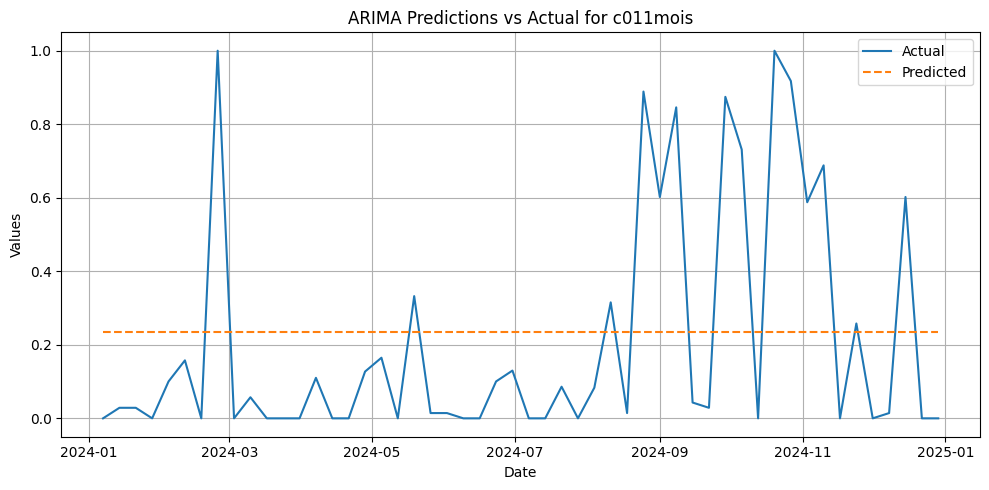

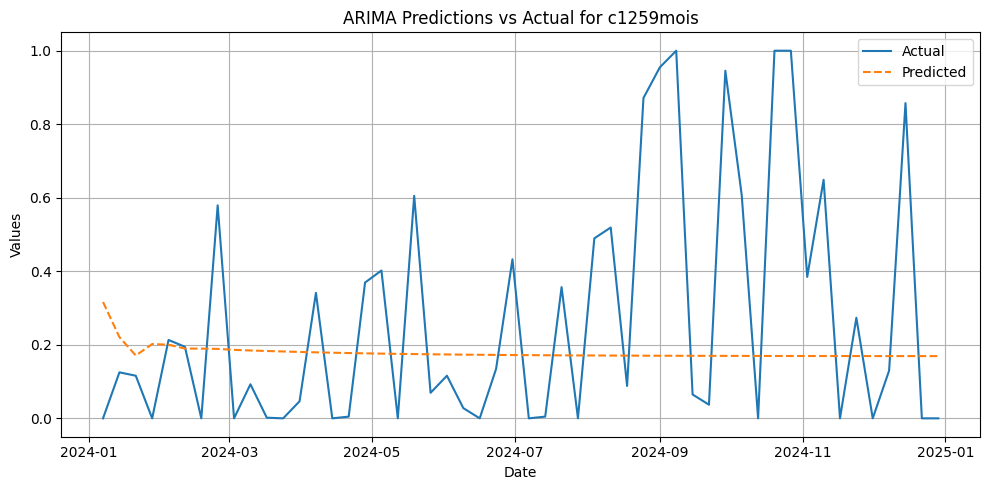

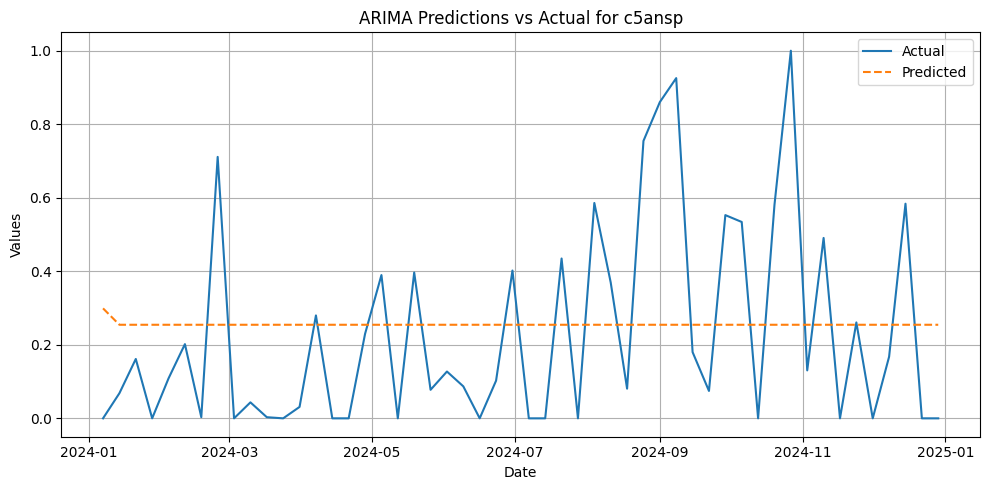

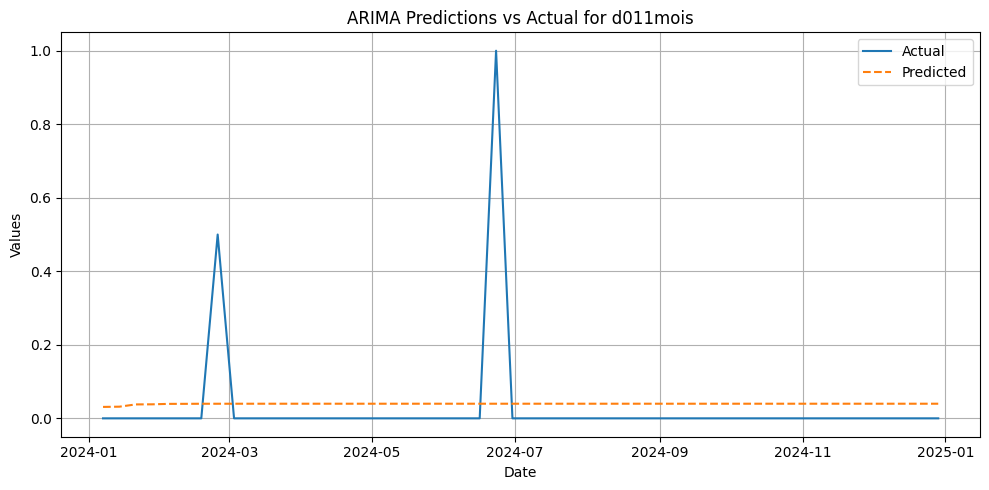

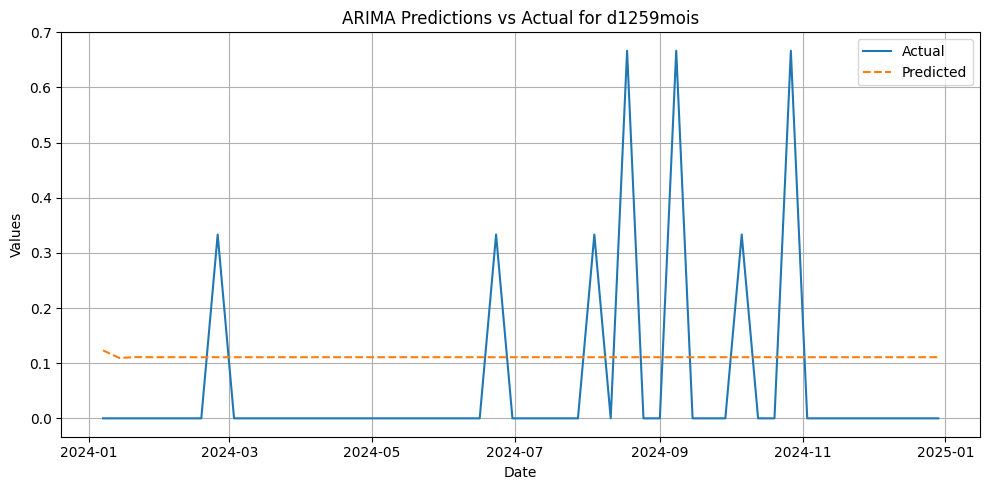

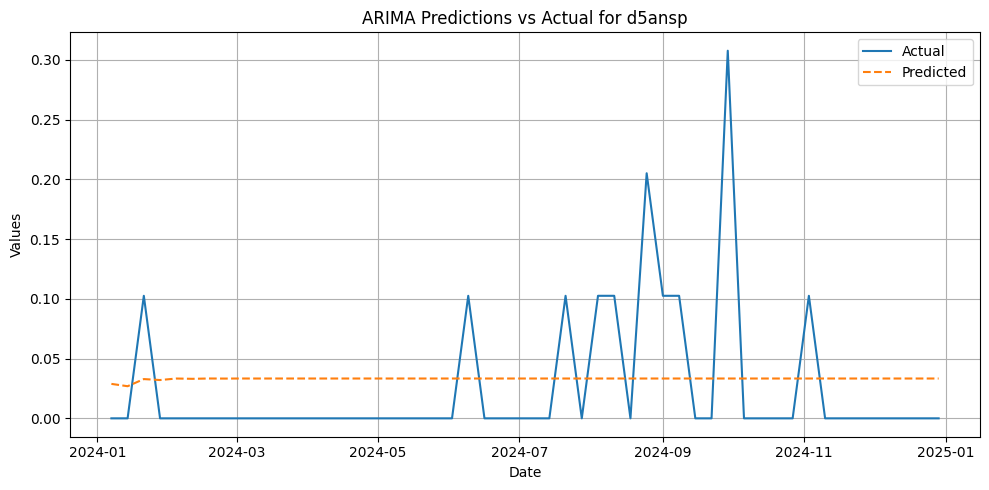

In [187]:
# Actual vs Prediction Plot for ARIMA
for col in target_columns:
    actual = df_weekly_arima[col].values[-52:]
    predicted = forecast_arima_results[f"ARIMA_{col}"]["yhat"].values[:52]
    plt.figure(figsize=(10,5))
    plt.plot(forecast_arima_results["ARIMA_2024"]["ds"], actual, label='Actual')
    plt.plot(forecast_arima_results["ARIMA_2024"]["ds"], predicted, label='Predicted', linestyle='--')
    plt.title(f'ARIMA Predictions vs Actual for {col}')
    plt.xlabel('Date')
    plt.ylabel('Values')
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

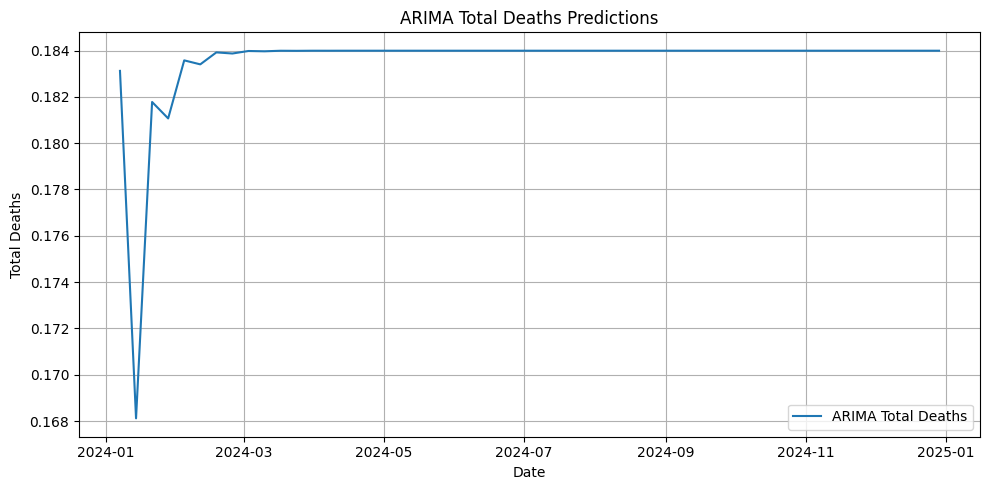

In [188]:
# Plot ARIMA total deaths
plt.figure(figsize=(10,5))
plt.plot(forecast_arima_results["ARIMA_2024"]["ds"], forecast_arima_results["ARIMA_2024"]["totaldeces"], label="ARIMA Total Deaths")
plt.xlabel("Date")
plt.ylabel("Total Deaths")
plt.title("ARIMA Total Deaths Predictions")
plt.legend()
plt.tight_layout()
plt.grid()
plt.show()

# **Comparative Analysis**

In [189]:
comparison_data = {"Model": ["Prophet", "SARIMA", "ARIMA"],
                   "R2 Score": [Prophet_r2, SARIMA_r2, ARIMA_r2], "MAE": [Prophet_mae, SARIMA_mae, ARIMA_mae],
                   "MSE": [Prophet_mse, SARIMA_mse, ARIMA_mse], "RMSE": [Prophet_rmse, SARIMA_rmse, ARIMA_rmse],}
comparison_df = pd.DataFrame(comparison_data)
print(comparison_df)

     Model   R2 Score       MAE       MSE      RMSE
0  Prophet -14.160671  1.023852  1.671272  1.292777
1   SARIMA   0.046032  0.058515  0.003425  0.058527
2    ARIMA  -0.012708  0.045923  0.003636  0.060302


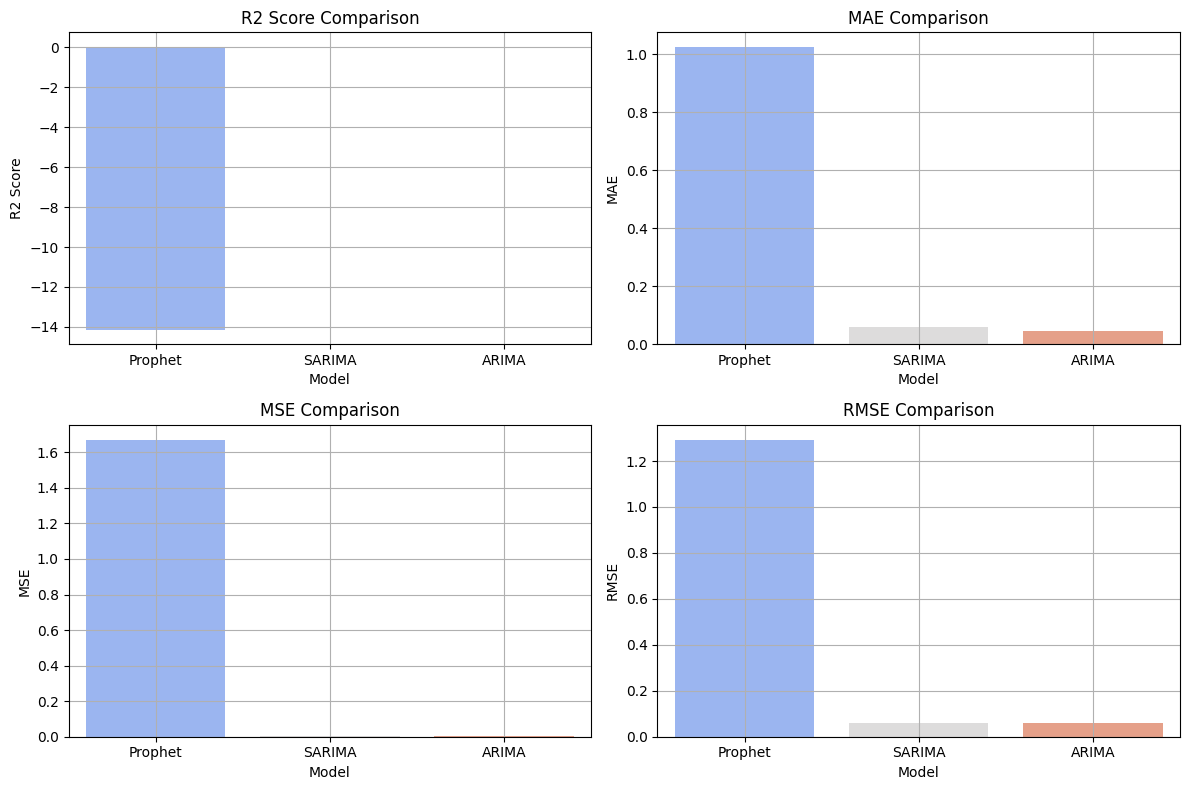

In [190]:
# Plot comparison graphs
metrics = ["R2 Score", "MAE", "MSE", "RMSE"]
plt.figure(figsize=(12, 8))
for i, metric in enumerate(metrics, 1):
    plt.subplot(2, 2, i)  # 2 rows, 2 columns
    sns.barplot(x="Model", y=metric, data=comparison_df, palette="coolwarm")
    plt.title(f"{metric} Comparison")
    plt.xlabel("Model")
    plt.ylabel(metric)
    plt.grid()

plt.tight_layout()
plt.show()

<Figure size 800x500 with 0 Axes>

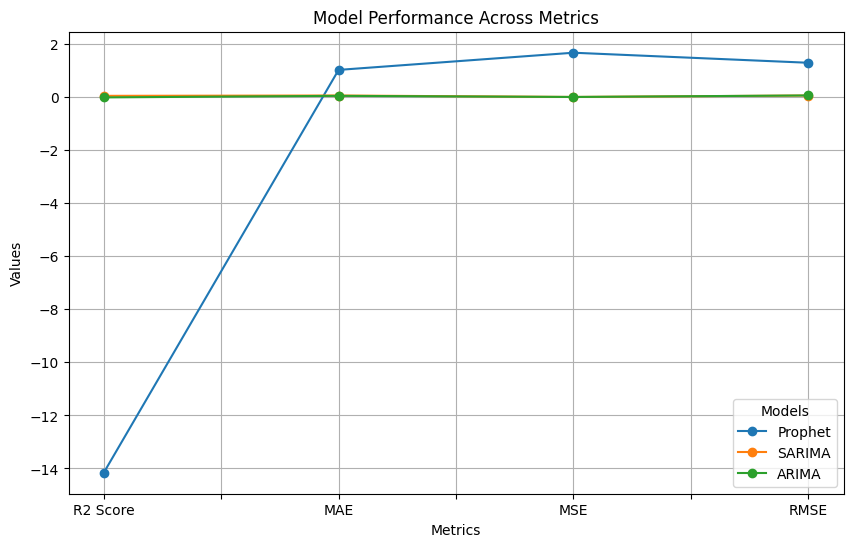

In [194]:
plt.figure(figsize=(8, 5))
comparison_df.set_index("Model").T.plot(marker='o', linestyle='-', figsize=(10,6))
plt.title("Model Performance Across Metrics")
plt.xlabel("Metrics")
plt.ylabel("Values")
plt.legend(title="Models")
plt.grid(True)
plt.show()